In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import cv2
import pathlib
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda,  BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras import applications

from time import time
from datetime import datetime

In [2]:
learning_rate = 0.001  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.001  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 1  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
batch_size = 50
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

In [3]:
use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = r'C:\Users\Previato\Fruit-Images-Dataset'  # relative path to the Fruit-Images-Dataset folder
test_dir = pathlib.Path(base_dir) / 'Test'
train_dir = pathlib.Path(base_dir) / 'Training'

output_dir = pathlib.Path(os.getcwd()) / 'Results'  # root folder in which to save the the output files; the files will be under output_files/model_name 

In [4]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
#     labels = [dir_name.split(" ")[0] for dir_name in os.listdir(train_dir)]
    labels = [dir_name for dir_name in os.listdir(train_dir)]
    labels = list(set(labels))
#     labels = np.array(sorted(labels))
num_classes = len(labels)

In [5]:
labels

['Potato Sweet',
 'Physalis with Husk',
 'Tomato not Ripened',
 'Potato White',
 'Pitahaya Red',
 'Kiwi',
 'Nectarine Flat',
 'Pear Monster',
 'Salak',
 'Corn',
 'Mulberry',
 'Limes',
 'Blueberry',
 'Mango',
 'Cocos',
 'Banana Red',
 'Kaki',
 'Cherry Wax Yellow',
 'Pepper Orange',
 'Pepper Yellow',
 'Pepper Green',
 'Strawberry',
 'Watermelon',
 'Cantaloupe',
 'Orange',
 'Quince',
 'Pomegranate',
 'Kohlrabi',
 'Tomato Maroon',
 'Granadilla',
 'Tomato Heart',
 'Cherry Wax Black',
 'Pear Abate',
 'Tomato',
 'Mango Red',
 'Tamarillo',
 'Nut Pecan',
 'Tomato Cherry Red',
 'Plum',
 'Ginger Root',
 'Cactus fruit',
 'Apricot',
 'Peach',
 'Nut Forest',
 'Avocado',
 'Nectarine',
 'Carambola',
 'Melon Piel de Sapo',
 'Beetroot',
 'Banana',
 'Strawberry Wedge',
 'Cauliflower',
 'Maracuja',
 'Grape Pink',
 'Kumquats',
 'Pepino',
 'Grapefruit White',
 'Cherry Wax Red',
 'Lemon',
 'Fig',
 'Pear Red',
 'Potato Red Washed',
 'Walnut',
 'Cherry Rainier',
 'Pineapple',
 'Grape White',
 'Mandarine',
 'Pe

In [6]:
list_train_ds = tf.data.Dataset.list_files(str(train_dir / '*/*'))
list_test_ds = tf.data.Dataset.list_files(str(test_dir / '*/*'))

In [7]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
#     img = img / 255.0
  # resize the image to the desired size
#   return tf.image.resize(img, [img_height, img_width])
    return img


def process_path(file_path):
#     print(file_path)
    label = tf.strings.split(file_path, os.sep)[-2]
#     K.print_tensor(label)
#     label = tf.strings.split(label, " ")[0]
#     print(labels)
#     K.print_tensor((labels == label))
    label = tf.argmax(tf.cast(labels == label, dtype=tf.int32))
    
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

In [8]:
def convert_image(x, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(x, alpha=alpha, beta=beta)

In [9]:
# Create a custom layer that converts the original image from
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4
def convert_to_hsv_and_grayscale(x):
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

In [10]:
# given the train and test folder paths and a validation to test ratio, this method creates three generators
#  - the training generator uses (100 - validation_percent) of images from the train set 
#    it applies random horizontal and vertical flips for data augmentation and generates batches randomly
#  - the validation generator uses the remaining validation_percent of images from the train set
#    does not generate random batches, as the model is not trained on this data
#    the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
#  - the test generator uses the test set without any form of augmentation
#    once the training process is done, the final values of accuracy and loss are calculated on this set
def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(224, 224), batch_size=50, convert=True):
    
    if convert:
        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images
            preprocessing_function=convert_image, 
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator(preprocessing_function=convert_image)
    
    else:
        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images,
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator()

    
    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen

In [11]:
labeled_train_ds = list_train_ds.map(process_path).shuffle(buffer_size=10000)
train_image_count = 6000

labeled_test_ds = list_test_ds.map(process_path)
# test_image_count = len(labeled_test_ds)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_data = configure_for_performance(labeled_train_ds.skip(train_image_count))
val_data = configure_for_performance(labeled_train_ds.take(train_image_count))

In [12]:
# create 2 charts, one for accuracy, one for loss, to show the evolution of these two metrics during the training process
def plot_model_history(model_history,name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    # save the graph in a file called "acc_loss.png" to be available for later; the model_name is provided when creating and training a model
    if name:
        plt.savefig(name)
    plt.show()

In [13]:
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt=".3f", linewidths=.2, cbar_kws={"shrink": 0.8})
    if name:
        plt.savefig(name)  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return plt

In [14]:
class CustomMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, labels, testGen, batch_size):
        super(CustomMetricsCallback, self).__init__()
        self.labels = labels
        self.testGen = testGen
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.testGen, steps=(self.testGen.n // self.batch_size) + 1)
        y_true = self.testGen.classes[self.testGen.index_array]
        plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), self.labels, name="batch_conf.png")
        img = cv2.imread("batch_conf.png")
        
        ret = tf.summary.image("conf_matrix", np.expand_dims(img, 0), step=epoch)

In [15]:
class BatchAccuracy(tf.keras.metrics.Metric):

    def __init__(self, batch_size=50,
                 name="batch_accuracy", **kwargs):
        super(BatchAccuracy, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size 

        self.batch_acc = self.add_weight(name="bacc", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

#         y_true = K.argmax(y_true, axis=-1)
        y_true = K.cast(y_true, dtype="float32")
#         K.print_tensor(y_true[:5])
        y_pred = K.argmax(y_pred, axis=-1)
        y_pred = K.cast(y_pred, dtype="float32")
#         K.print_tensor(y_pred[:5])
        # K.print_tensor(K.shape(y_pred))
        y_true = K.flatten(y_true)

        true = K.sum(K.cast(K.equal(y_true, y_pred), dtype=tf.float32))
        #K.print_tensor(K.cast(K.equal(y_true, y_pred), dtype=tf.float32))
        #K.print_tensor(K.shape(K.equal(y_true, y_pred)))

        # K.print_tensor(K.int_shape(y_pred))
        self.batch_acc.assign(true / K.cast(K.shape(y_pred), dtype=tf.float32)[0])

    def result(self):

        return self.batch_acc

In [16]:
# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, conf, optimizer, epochs=25, batch_size=50, verbose=verbose, useCkpt=False, convert=False):
    print(model.summary())
    
    conf = conf + str(convert)
    date_str = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    model_name = "model" + "-" + conf + ".h5"
    model_out_dir = output_dir / date_str
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    
    logdir = "logs/fc_normal-%s" % date_str
  
    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, 
                                                             labels=labels, image_size=image_size, batch_size=batch_size,
                                                             convert=convert)
    
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy", BatchAccuracy(batch_size=batch_size)])
      
#     file_writer = tf.summary.create_file_writer(logdir + "/metrics")
#     file_writer.set_as_default()

    test_data = configure_for_performance(labeled_test_ds)

    save_model = ModelCheckpoint(filepath=str(model_out_dir / model_name),
                                 monitor='val_accuracy',
                                 verbose=verbose, 
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='max',
                                 save_freq='epoch')
    
    tbCallBack = TensorBoard(log_dir=logdir,
                             write_graph=True,
                             update_freq=10)
    
    history = model.fit(trainGen,
                        epochs=epochs,
                        steps_per_epoch=(trainGen.n // batch_size) + 1,
                        validation_data=validationGen,
                        validation_steps=(validationGen.n // batch_size) + 1,
                        verbose=verbose,
                        callbacks=[save_model, tbCallBack]
                        )

    model.load_weights(str(model_out_dir / model_name))

    validationGen.reset()
    loss_v, accuracy_v, _ = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy, _ = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
#     loss_v, accuracy_v, _ = model.evaluate(validationGen, verbose=verbose)
#     loss, accuracy, _ = model.evaluate(testGen, verbose=verbose)
    
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

    plot_model_history(history, name=model_out_dir / ("acc_loss-" + conf + ".png"))

    testGen.reset()
    y_pred = model.predict(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
#     y_pred = model.predict(test_data, verbose=verbose)

#     y_true = np.array([], dtype=np.int64)
#     for _, label in test_data:
#         y_true = np.concatenate((y_true, label.numpy()))
    y_true = testGen.classes[testGen.index_array]

    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, name=model_out_dir / ("confusion_matrix-" + conf + ".png"))
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)


    with open(model_out_dir / ("classification_report-" + conf + ".txt"), "w") as text_file:
        text_file.write("%s" % class_report)

In [17]:
def network_one(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('elu', name='conv1_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('elu', name='conv2_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv3')(x)
    x = Activation('elu', name='conv3_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='conv4')(x)
    x = Activation('elu', name='conv4_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_elu (Activation)       (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 32)        12832     
_________________________________________________________________
conv2_elu (Activation)       (None, 25, 25, 32)        0     

1218/1219 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9918 - batch_accuracy: 0.9800
Epoch 00013: val_accuracy did not improve from 0.98176
1219/1219 [==============================] - 34s 28ms/step - loss: 0.0326 - accuracy: 0.9918 - batch_accuracy: 1.0000 - val_loss: 0.4096 - val_accuracy: 0.9233 - val_batch_accuracy: 1.0000
Epoch 14/20
1218/1219 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9935 - batch_accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.98176
1219/1219 [==============================] - 34s 28ms/step - loss: 0.0248 - accuracy: 0.9936 - batch_accuracy: 1.0000 - val_loss: 0.3357 - val_accuracy: 0.9540 - val_batch_accuracy: 1.0000
Epoch 15/20
1219/1219 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9939 - batch_accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.98176
1219/1219 [==============================] - 35s 28ms/step - loss: 0.0242 - accuracy: 0.9939 - ba

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


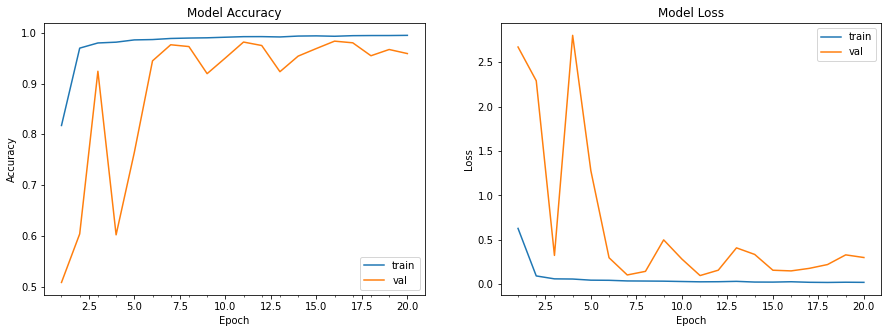

454/454 [==============================] - 11s 24ms/step


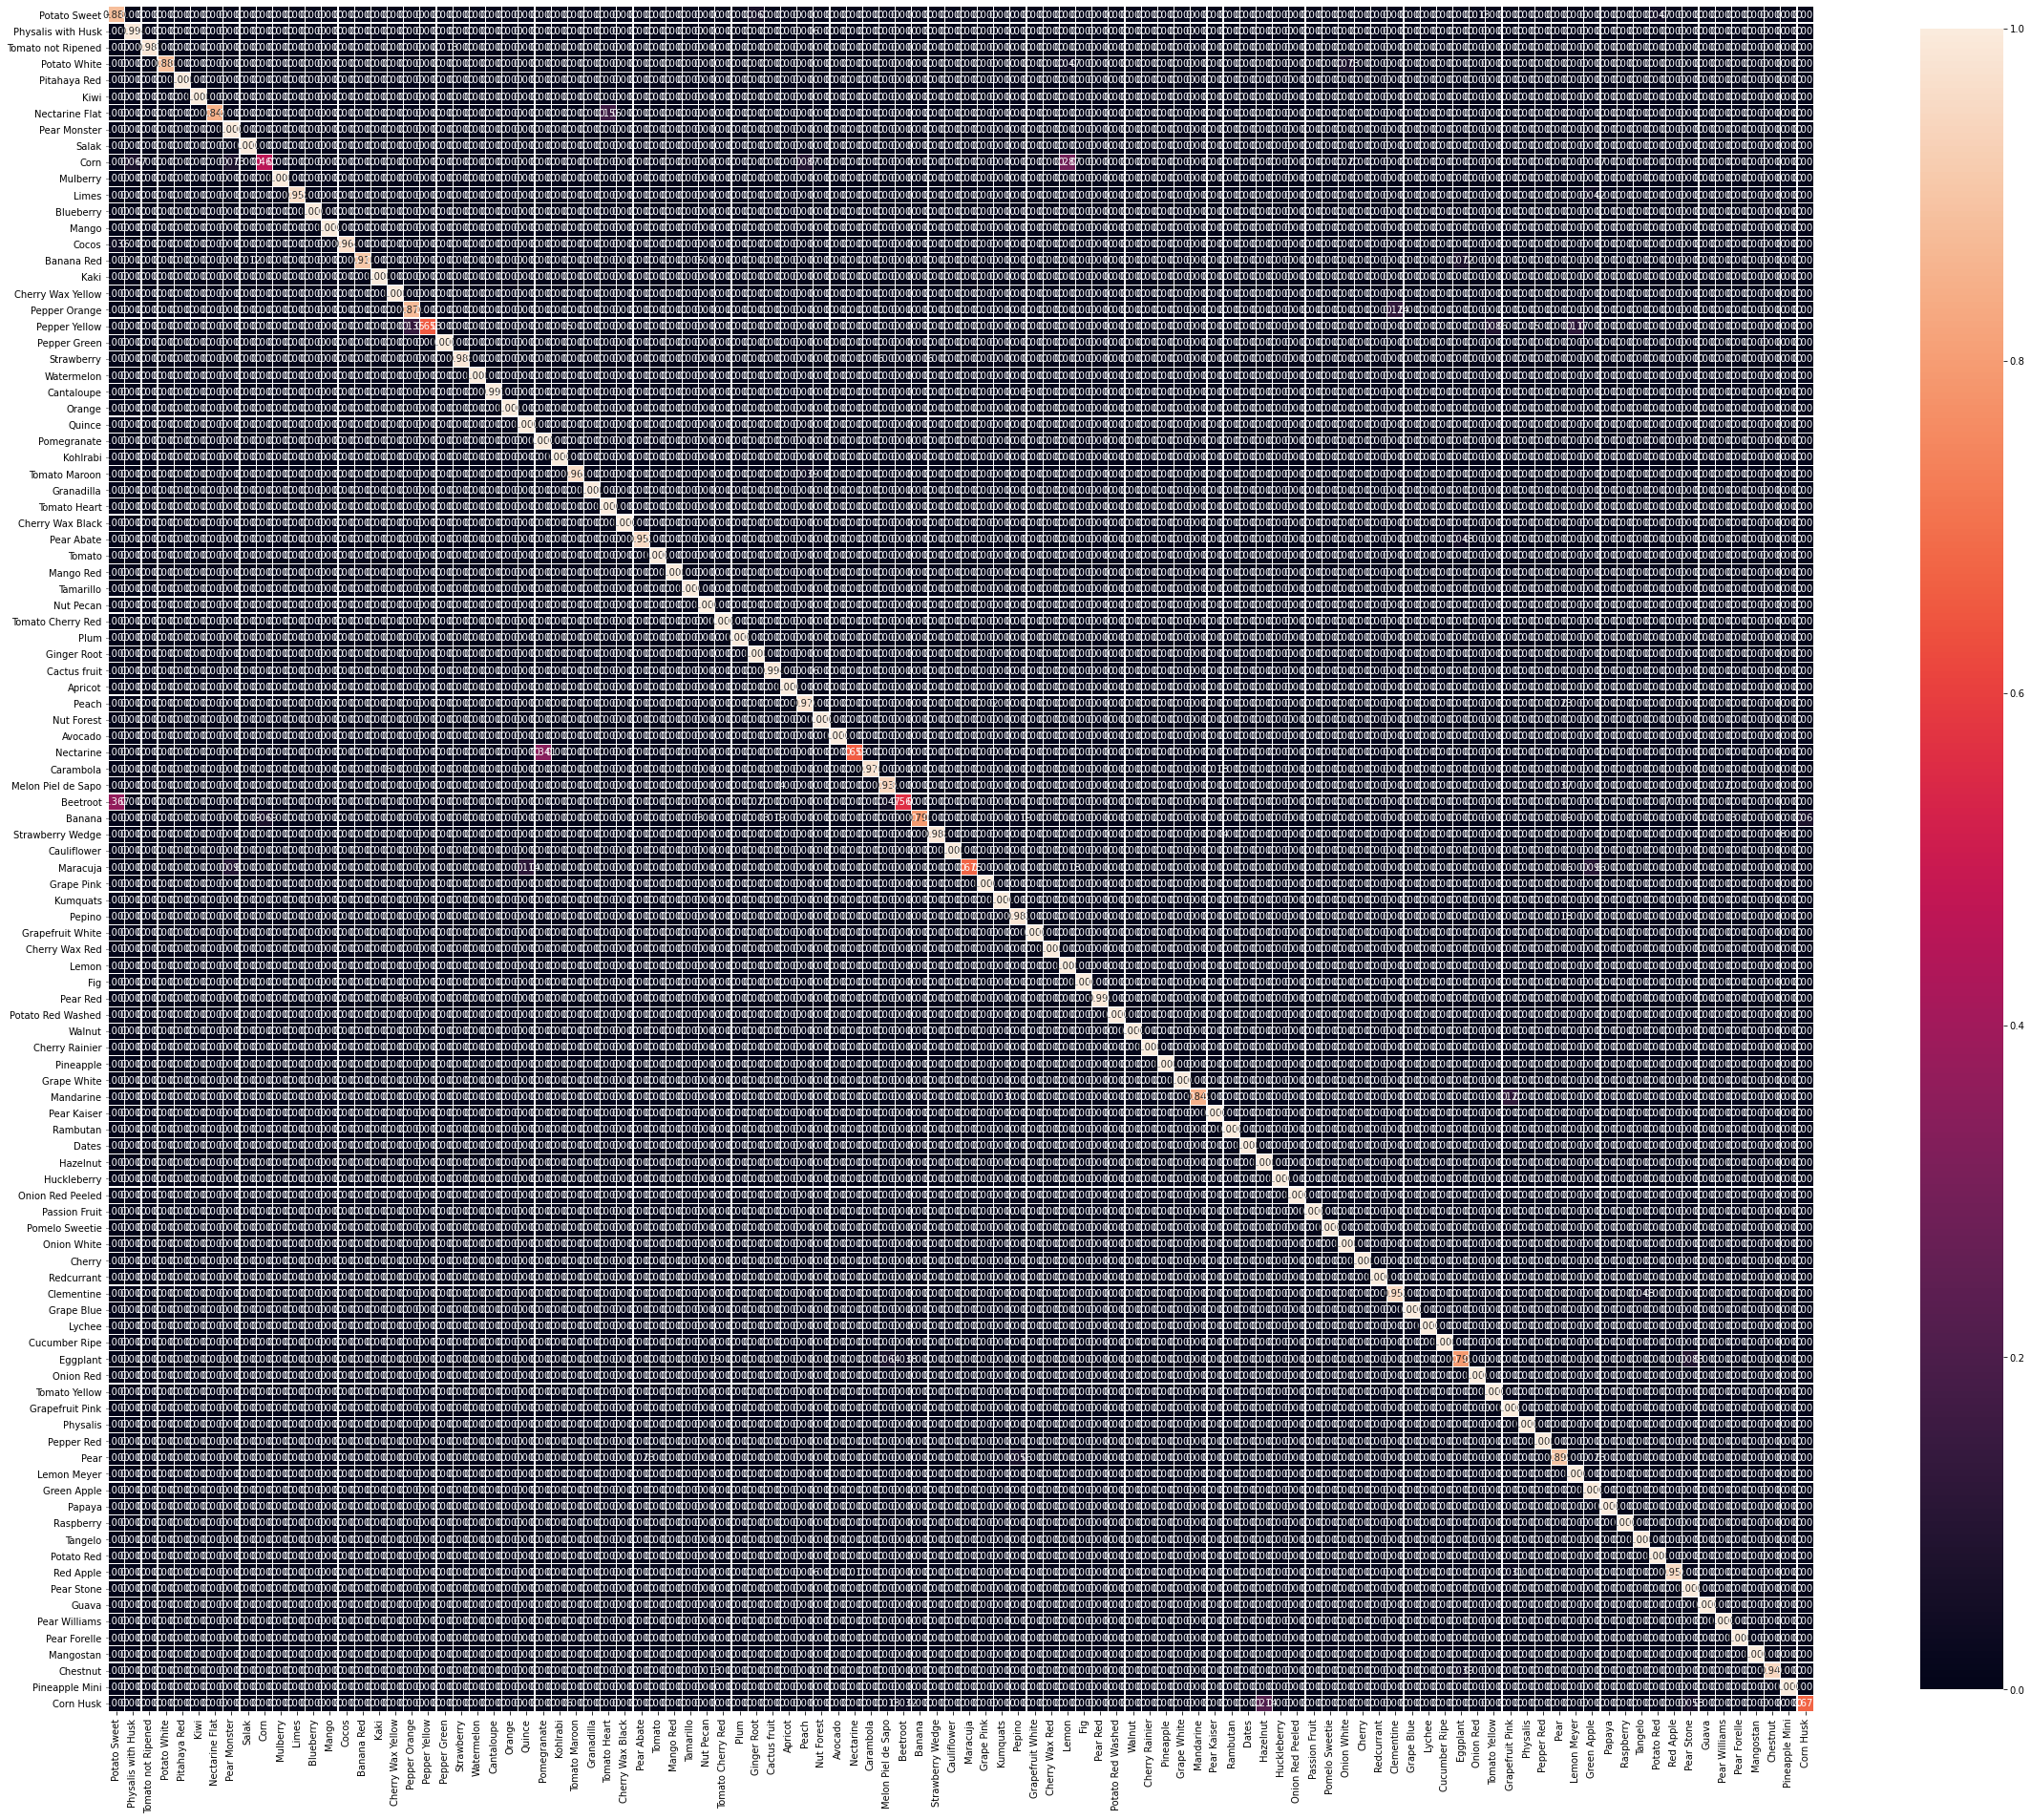

In [18]:
model = network_one(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "n1-adam", optimizer, epochs=20, convert=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_elu (Activation)       (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 50, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 32)        12832     
_________________________________________________________________
conv2_elu (Activation)       (None, 25, 25, 32)        0   

1217/1219 [============================>.] - ETA: 0s - loss: 3.3476 - accuracy: 0.2139 - batch_accuracy: 0.1600
Epoch 00011: val_accuracy improved from 0.21797 to 0.23725, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-16-38-50\model-n1-deltaTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 3.3475 - accuracy: 0.2140 - batch_accuracy: 0.3000 - val_loss: 3.1754 - val_accuracy: 0.2372 - val_batch_accuracy: 1.0000
Epoch 12/20
1218/1219 [============================>.] - ETA: 0s - loss: 3.2613 - accuracy: 0.2228 - batch_accuracy: 0.2800
Epoch 00012: val_accuracy improved from 0.23725 to 0.25163, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-16-38-50\model-n1-deltaTrue.h5
1219/1219 [==============================] - 34s 28ms/step - loss: 3.2612 - accuracy: 0.2228 - batch_accuracy: 0.2400 - val_loss: 3.0807 - val_accuracy: 0.2516 - val_batch_accuracy: 1.0000
Epoch 13/20
1218/1219 [============================>.] - ETA: 0s - l

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


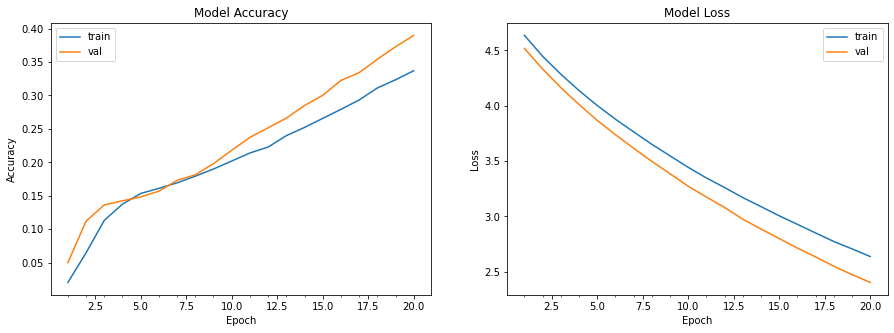

454/454 [==============================] - 11s 23ms/step


c:\users\previato\divertidamente\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


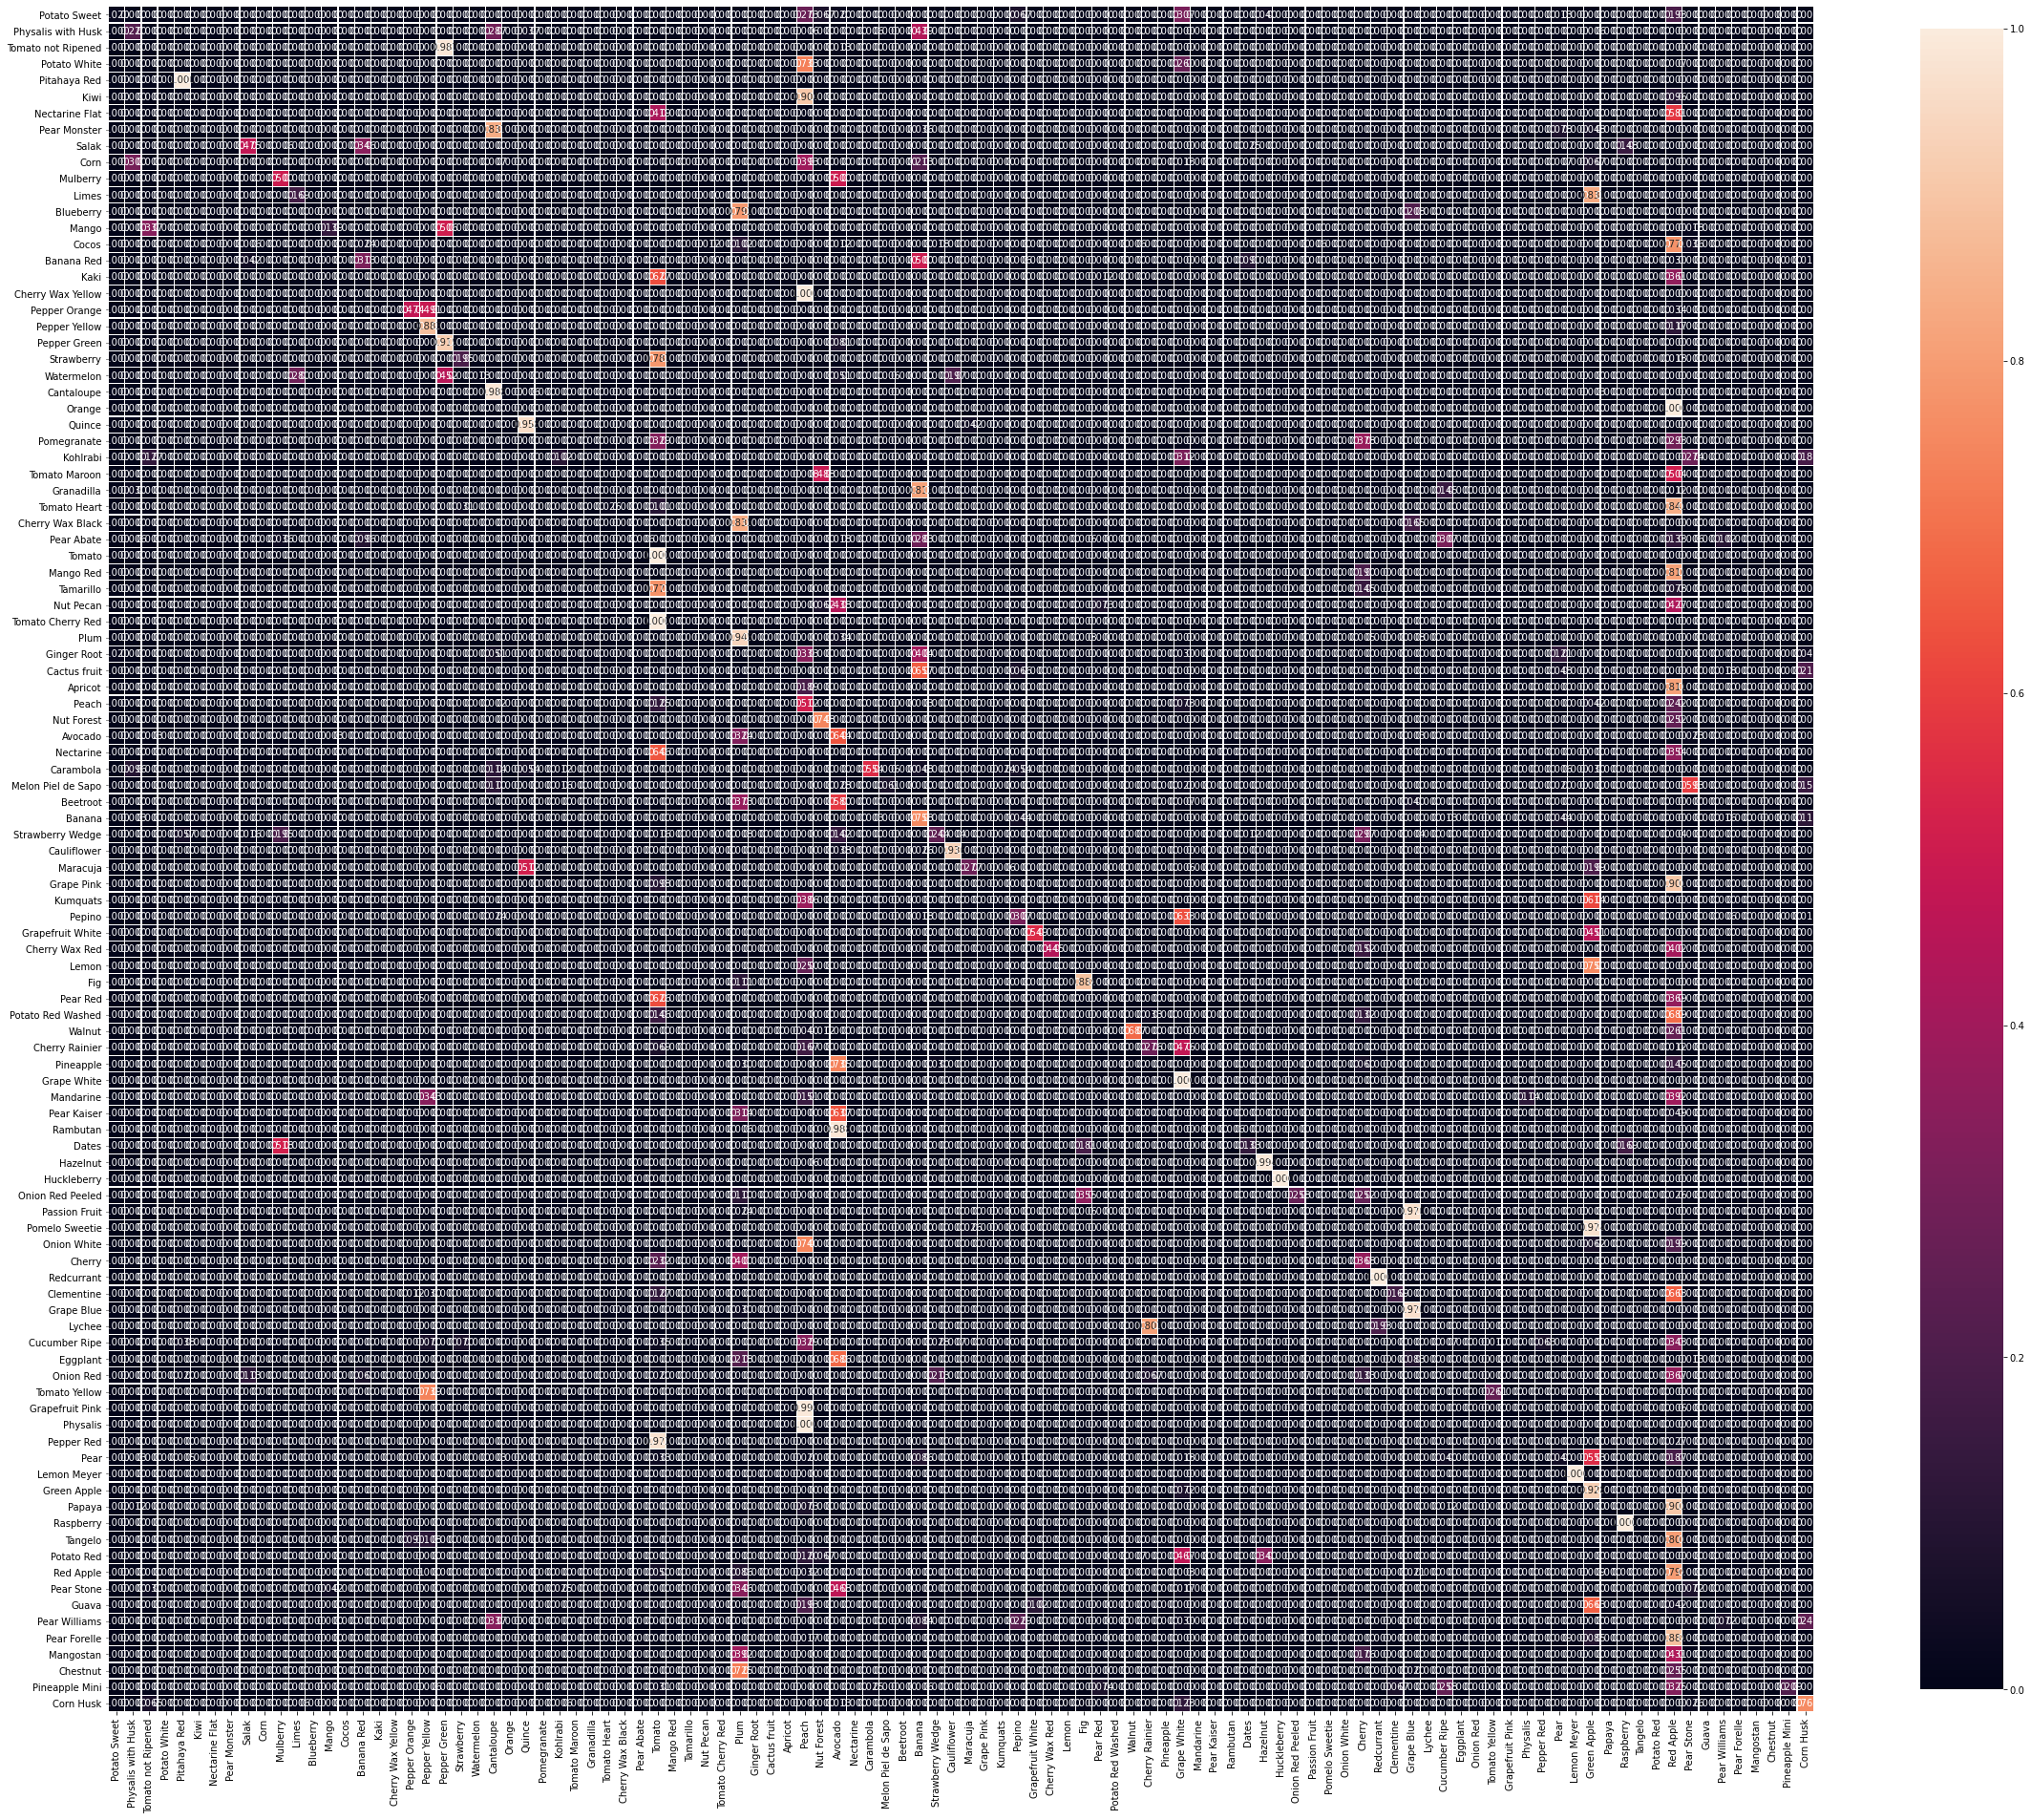

In [19]:
model = network_one(input_shape=input_shape, num_classes=num_classes)
optimizer = Adadelta(lr=learning_rate)
train_and_evaluate_model(model, "n1-delta", optimizer, epochs=20, convert=True)

In [20]:
def network_two(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('elu', name='conv1_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('elu', name='conv2_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv3')(x)
    x = Activation('elu', name='conv3_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='conv4')(x)
    x = Activation('elu', name='conv4_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_elu (Activation)       (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 32)        12832     
_________________________________________________________________
conv2_elu (Activation)       (None, 25, 25, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 32)        0   

Epoch 15/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.9345 - batch_accuracy: 0.8600
Epoch 00015: val_accuracy did not improve from 0.96456
1219/1219 [==============================] - 33s 27ms/step - loss: 0.3189 - accuracy: 0.9345 - batch_accuracy: 0.8600 - val_loss: 0.3781 - val_accuracy: 0.9477 - val_batch_accuracy: 1.0000
Epoch 16/20
1217/1219 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.9326 - batch_accuracy: 0.9600
Epoch 00016: val_accuracy did not improve from 0.96456
1219/1219 [==============================] - 33s 27ms/step - loss: 0.3433 - accuracy: 0.9326 - batch_accuracy: 1.0000 - val_loss: 0.5282 - val_accuracy: 0.9520 - val_batch_accuracy: 1.0000
Epoch 17/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.9333 - batch_accuracy: 0.9000- ETA: 0s - loss: 0.3398 - accuracy: 0.9336 - batch_accuracy
Epoch 00017: val_accuracy did not improve from 0.96456
1219/1219 [==============

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


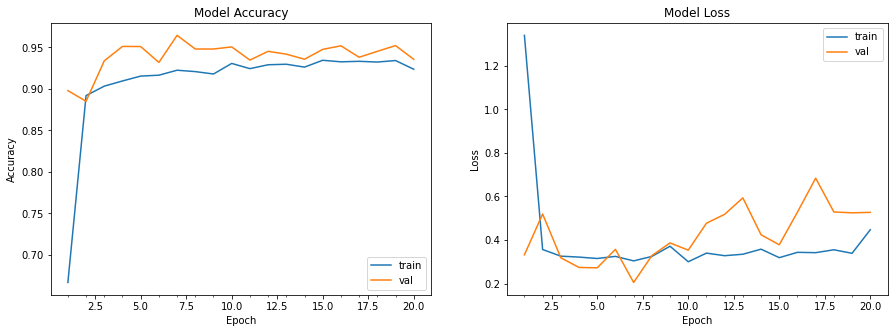

454/454 [==============================] - 10s 23ms/step


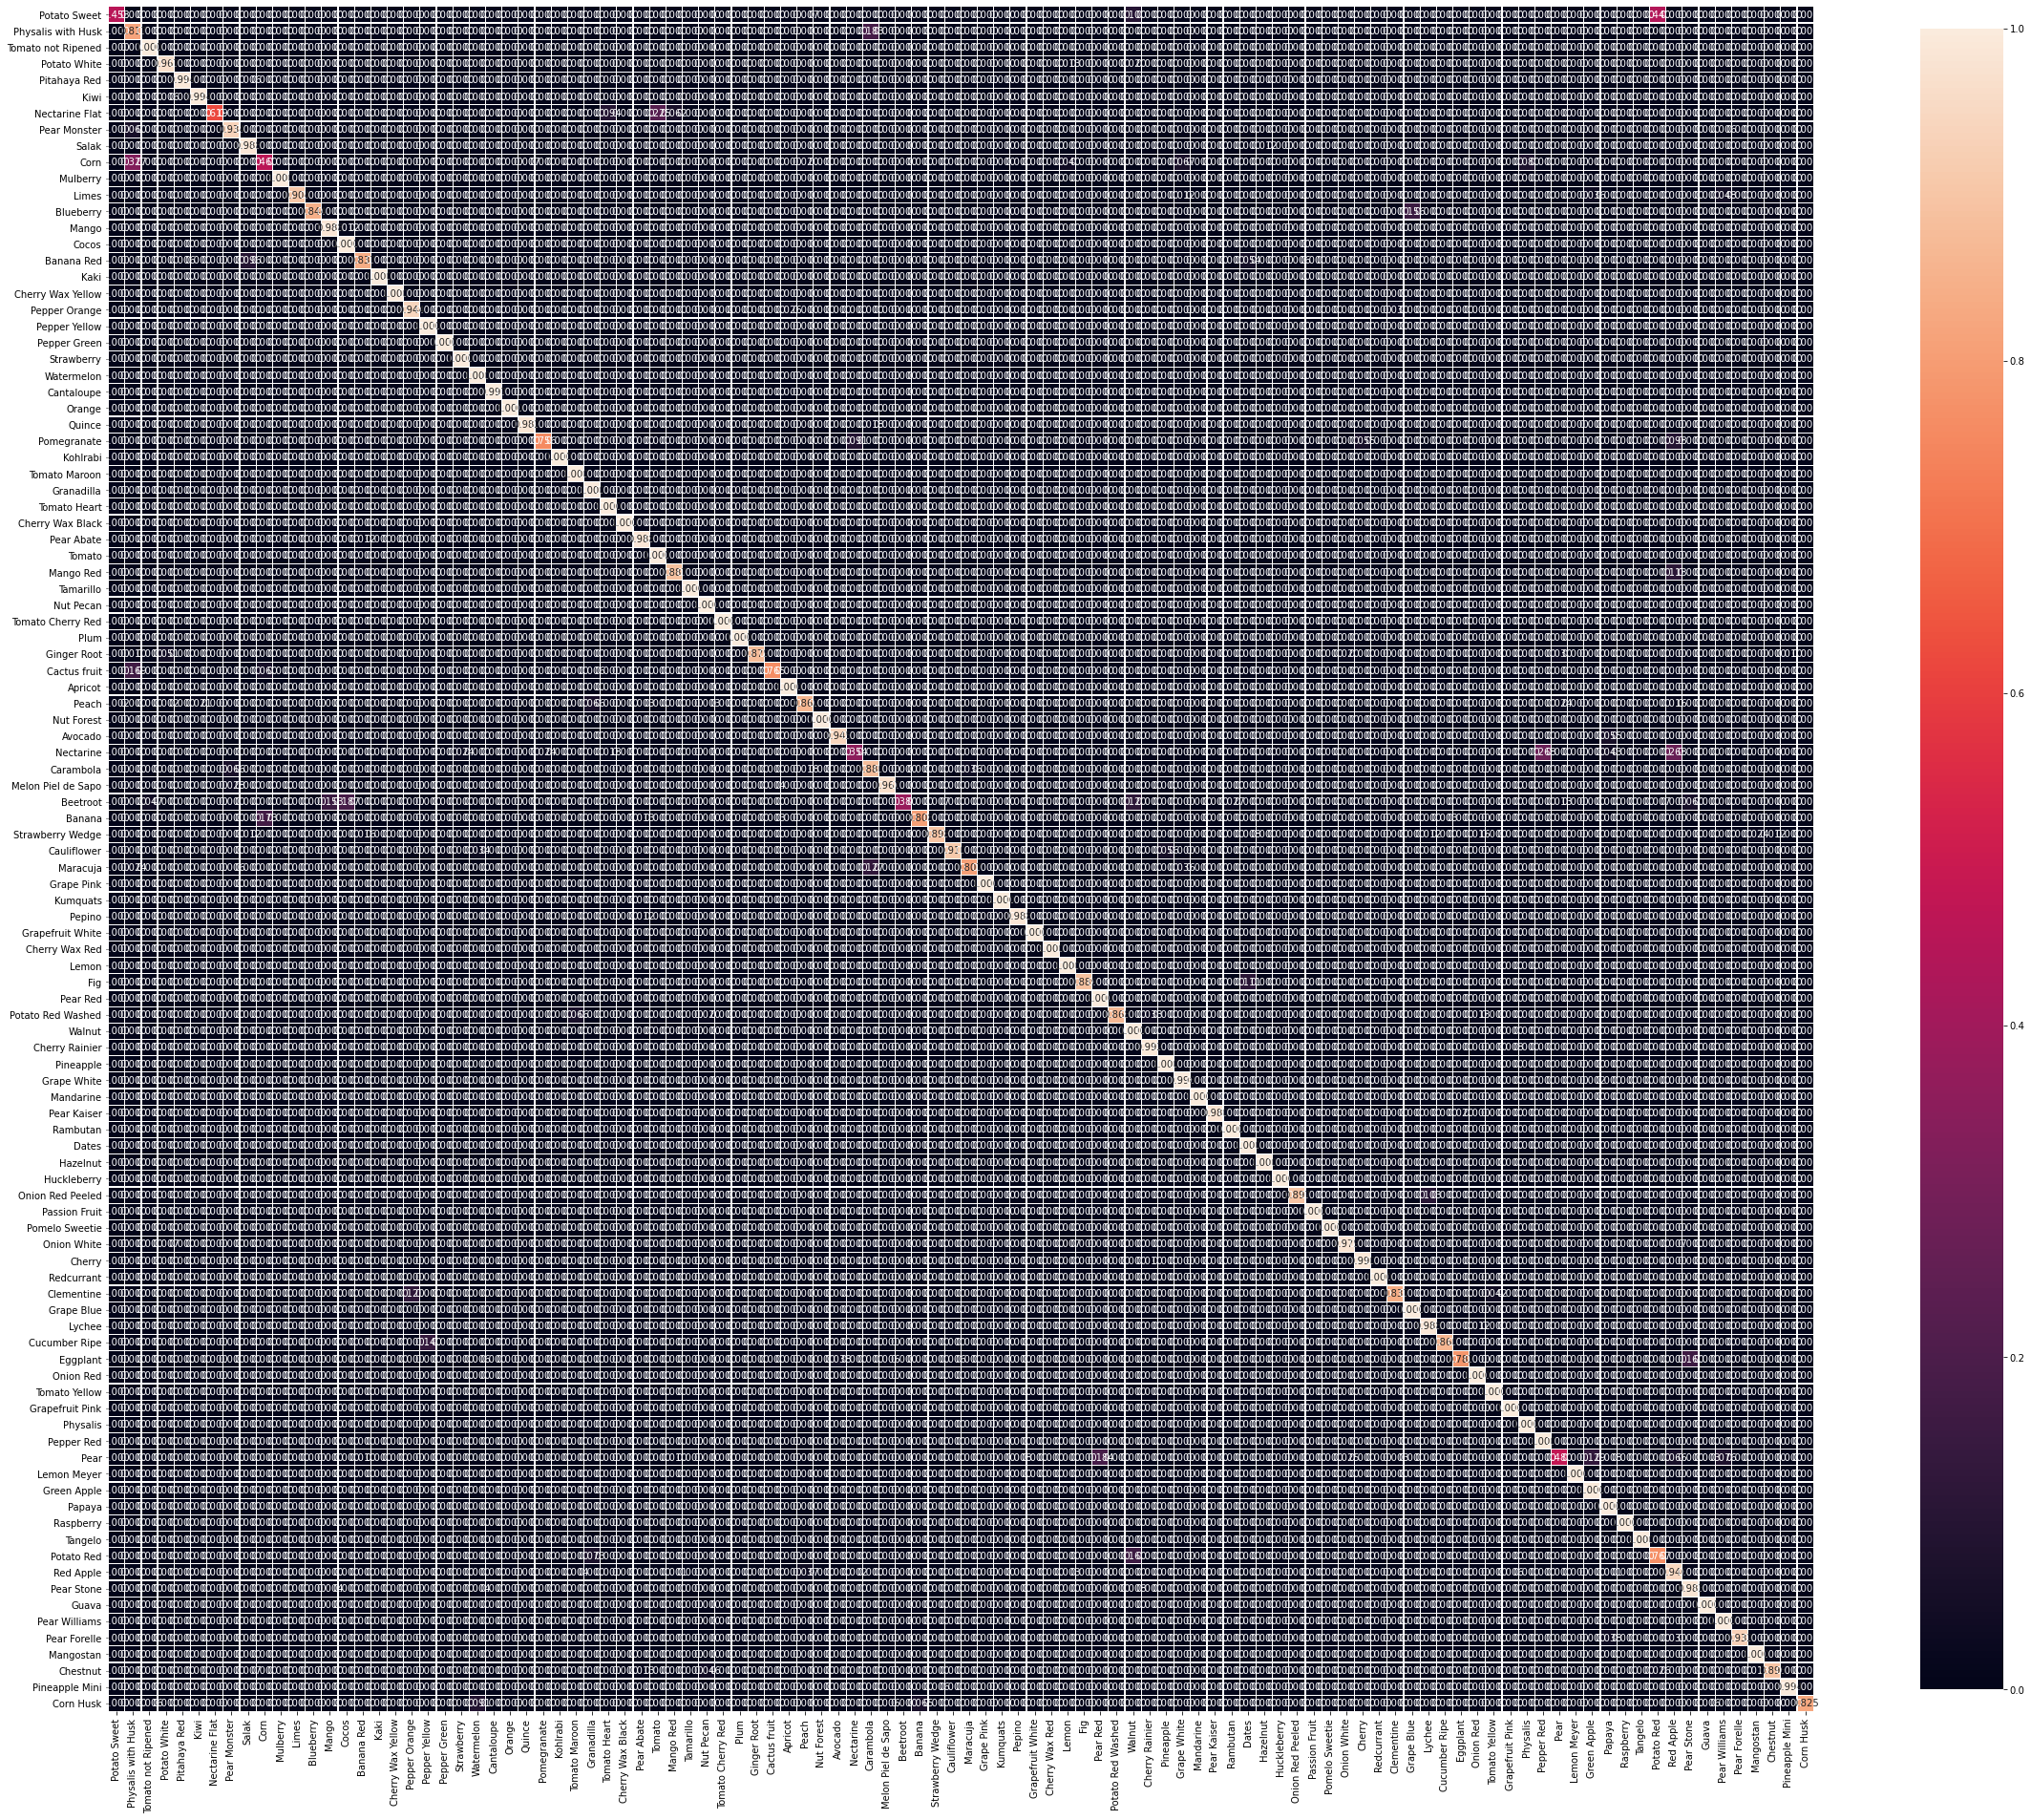

In [21]:
model = network_two(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "n2-adam", optimizer, epochs=20, convert=True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_elu (Activation)       (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 32)        12832     
_________________________________________________________________
conv2_elu (Activation)       (None, 25, 25, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 32)        0   

1219/1219 [==============================] - ETA: 0s - loss: 3.9910 - accuracy: 0.1395 - batch_accuracy: 0.1600- ETA: 0s - loss: 3.9913 - accuracy: 0.1394 - batch_accuracy
Epoch 00012: val_accuracy improved from 0.21278 to 0.22464, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-05-50\model-n2-deltaTrue.h5
1219/1219 [==============================] - 34s 28ms/step - loss: 3.9910 - accuracy: 0.1395 - batch_accuracy: 0.1600 - val_loss: 3.4348 - val_accuracy: 0.2246 - val_batch_accuracy: 0.0000e+00
Epoch 13/20
1218/1219 [============================>.] - ETA: 0s - loss: 3.9265 - accuracy: 0.1477 - batch_accuracy: 0.1200
Epoch 00013: val_accuracy improved from 0.22464 to 0.22894, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-05-50\model-n2-deltaTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 3.9265 - accuracy: 0.1477 - batch_accuracy: 0.1200 - val_loss: 3.3745 - val_accuracy: 0.2289 - val_batch_accuracy: 0.0000e+00


<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


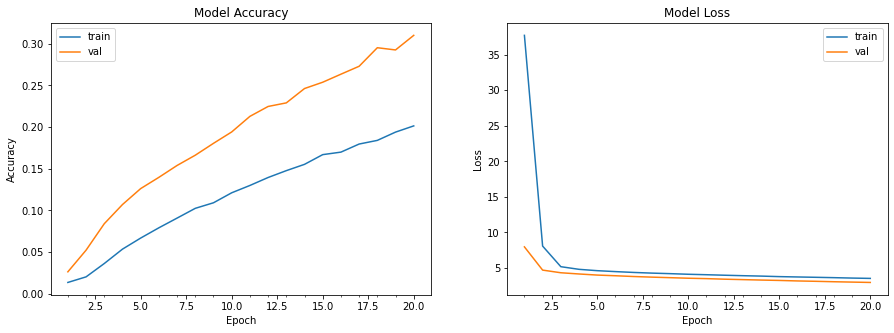

454/454 [==============================] - 10s 23ms/step


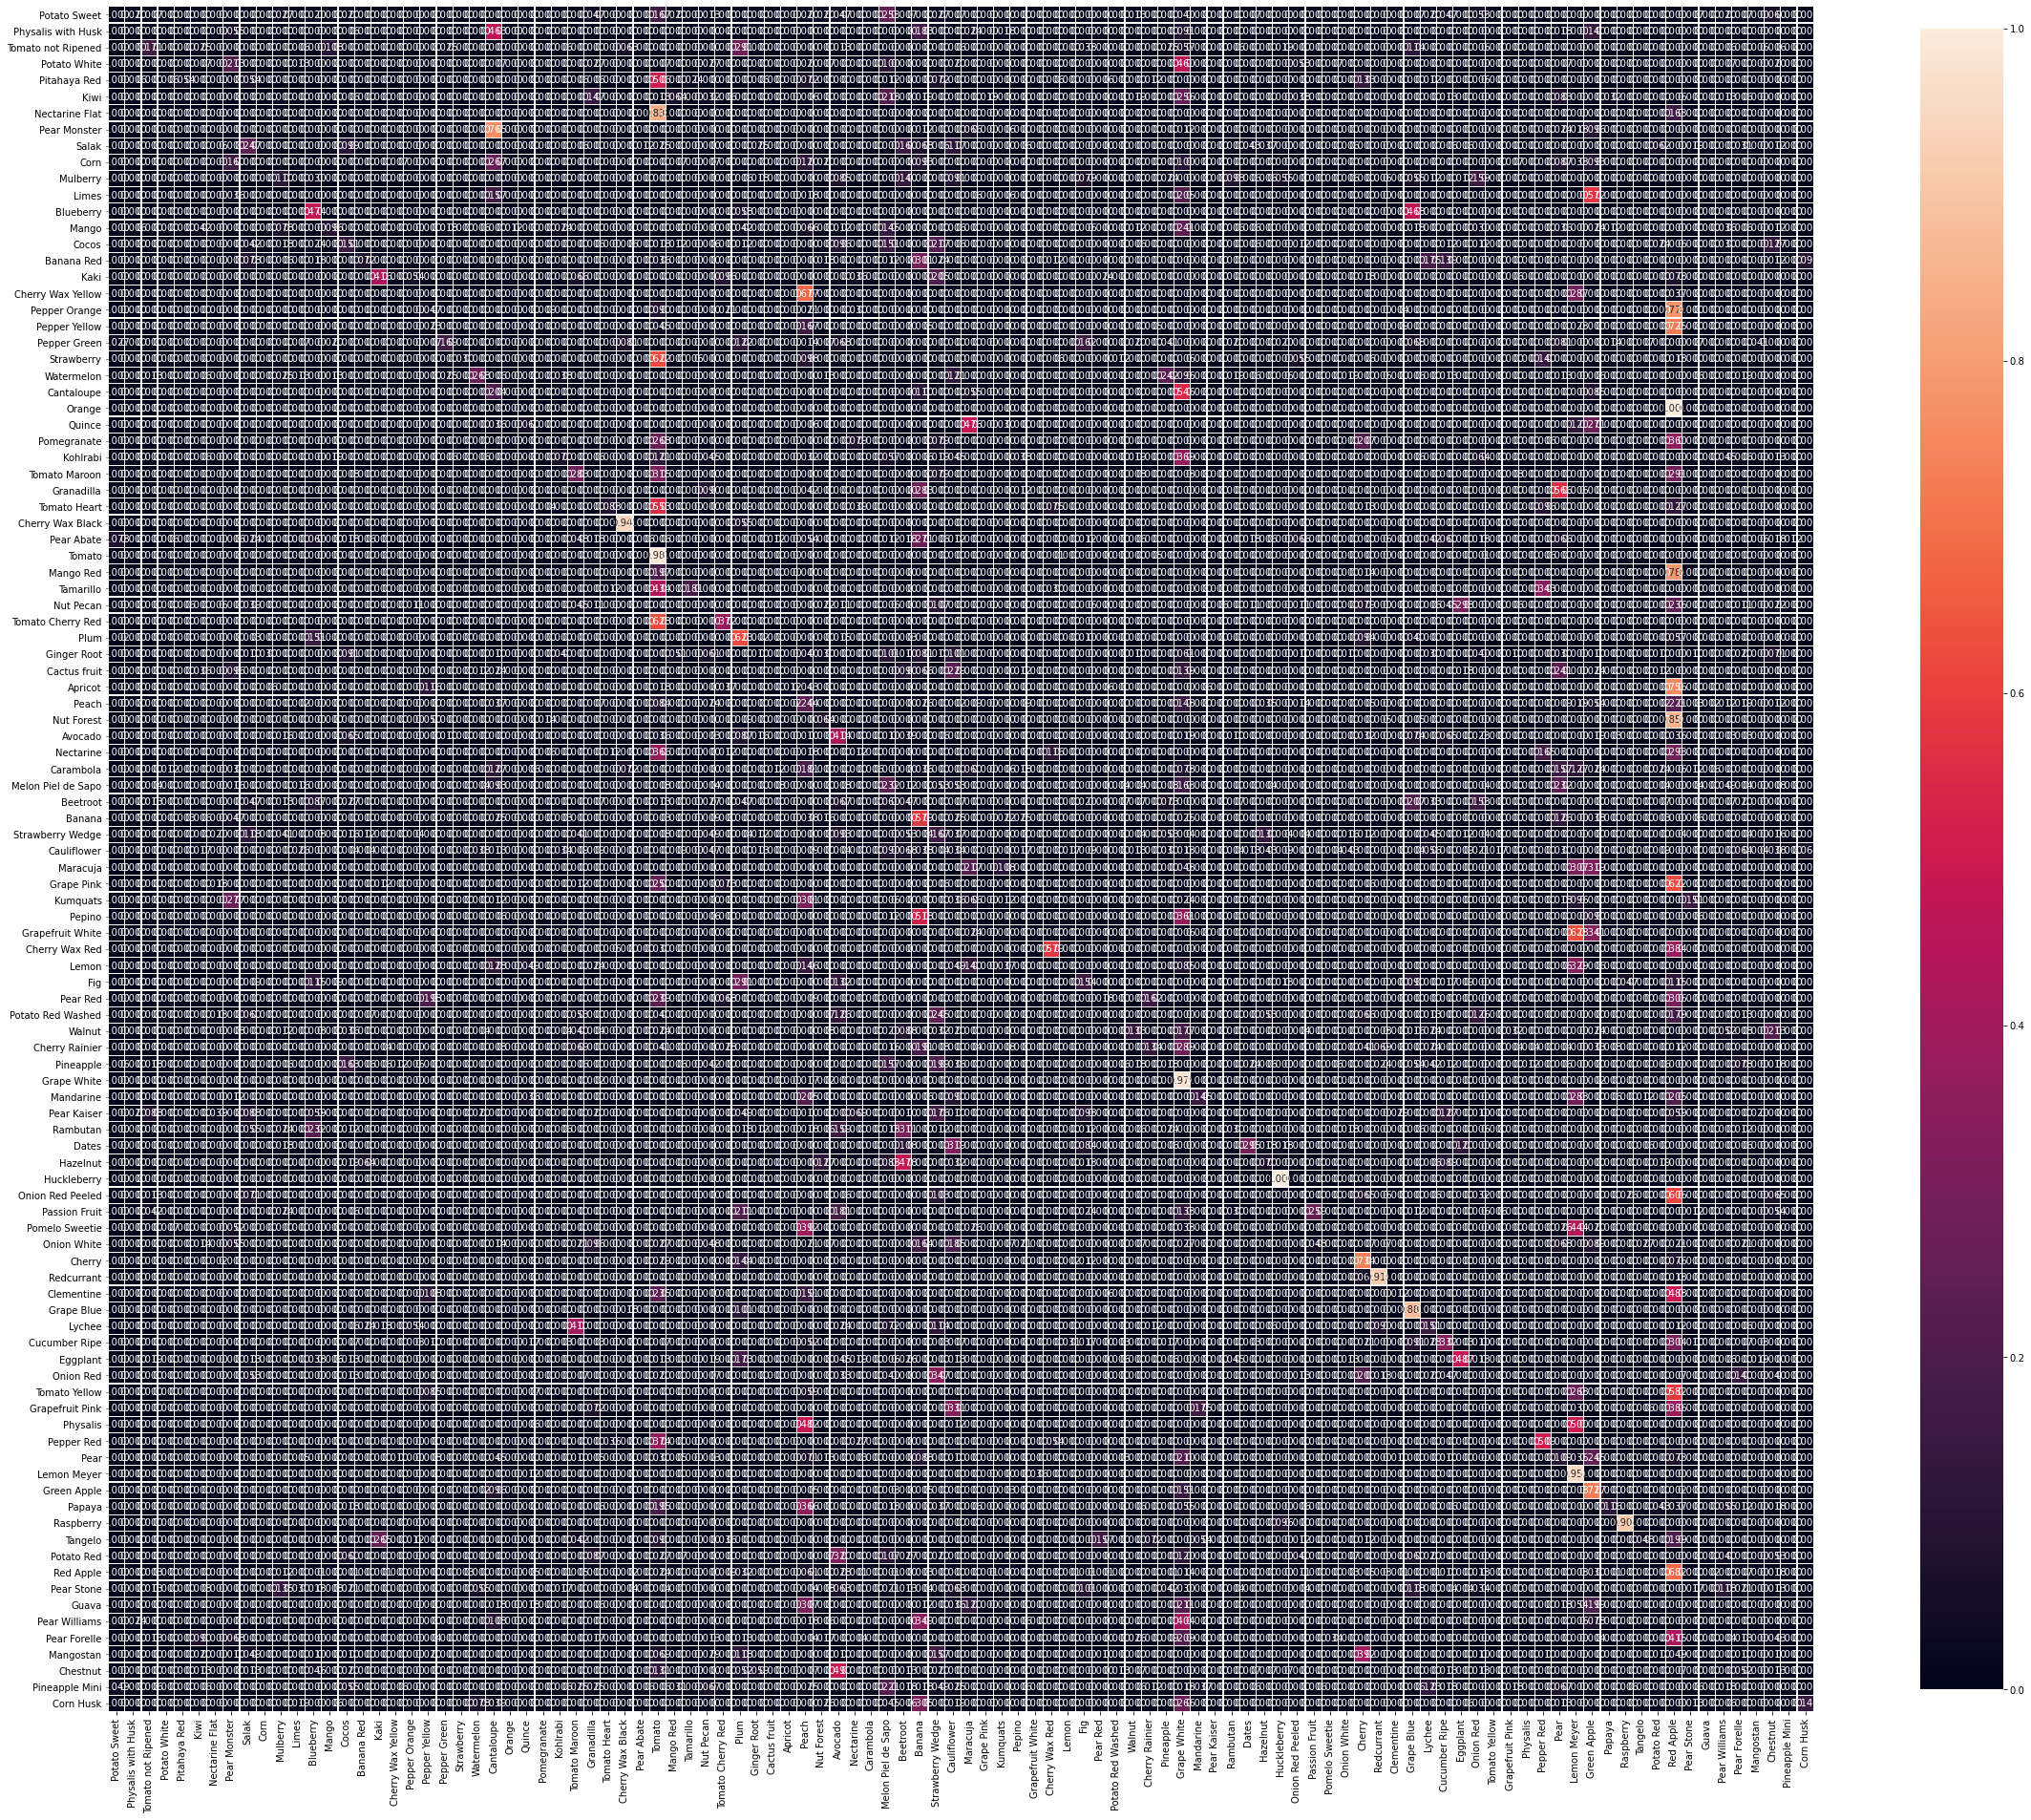

In [22]:
model = network_two(input_shape=input_shape, num_classes=num_classes)
optimizer = Adadelta(lr=learning_rate)
train_and_evaluate_model(model, "n2-delta", optimizer, epochs=20, convert=True)

In [23]:
def network_three(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fcl2')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 16)        1216      
_________________________________________________________________
conv1_relu (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 25, 25, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 13, 13, 32)        0   

1219/1219 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9942 - batch_accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.97183
1219/1219 [==============================] - 33s 27ms/step - loss: 0.0191 - accuracy: 0.9942 - batch_accuracy: 1.0000 - val_loss: 0.4850 - val_accuracy: 0.9199 - val_batch_accuracy: 1.0000
Epoch 15/20
1218/1219 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9934 - batch_accuracy: 1.0000
Epoch 00015: val_accuracy improved from 0.97183 to 0.98413, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-19-18\model-n3-adamTrue.h5
1219/1219 [==============================] - 34s 28ms/step - loss: 0.0216 - accuracy: 0.9934 - batch_accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 0.9841 - val_batch_accuracy: 1.0000
Epoch 16/20
1218/1219 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9947 - batch_accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


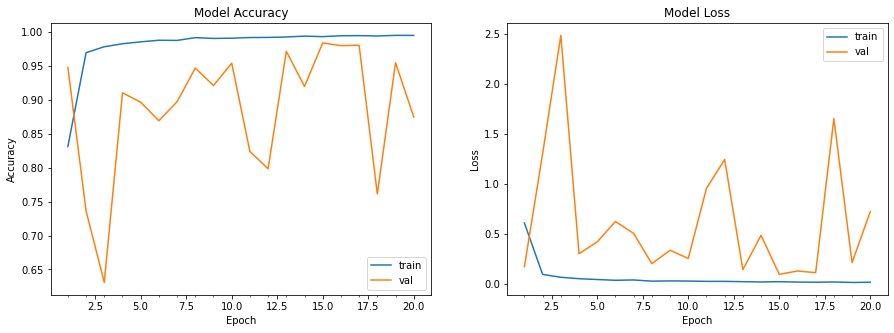

454/454 [==============================] - 10s 23ms/step


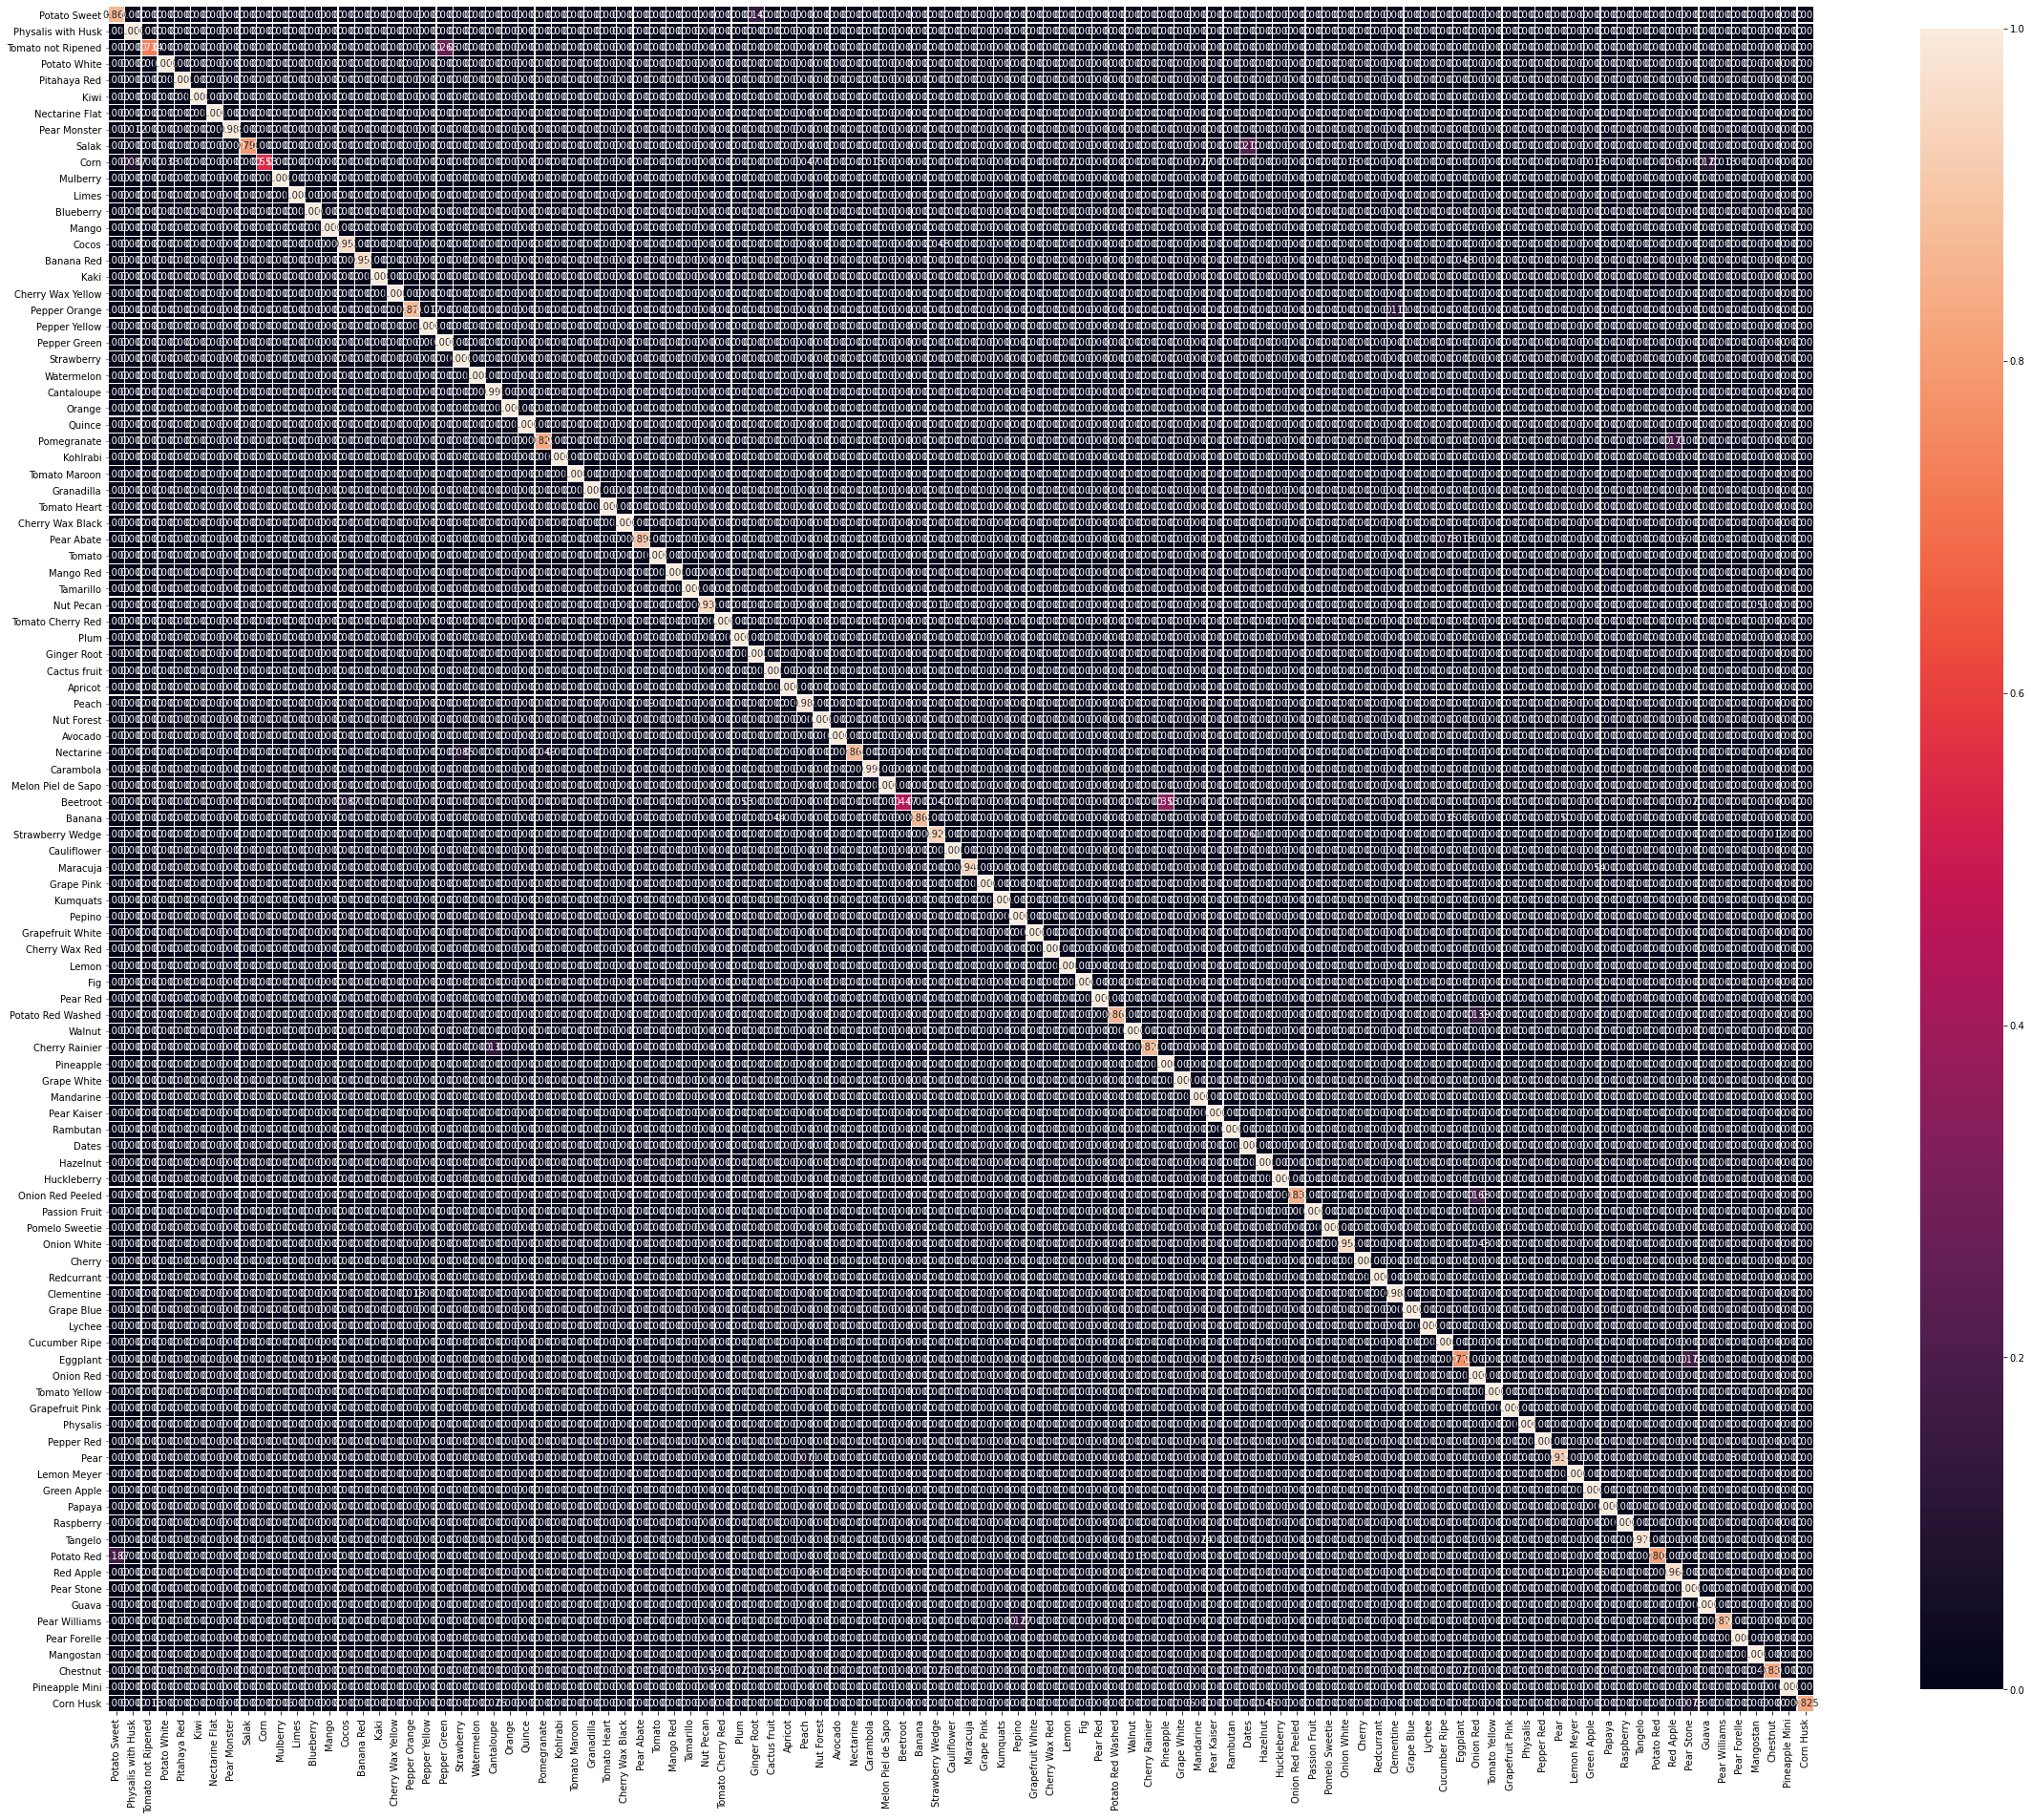

In [24]:
model = network_three(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "n3-adam", optimizer, epochs=20, convert=True)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 16)        1216      
_________________________________________________________________
conv1_relu (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 25, 25, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 25, 25, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 13, 13, 32)        0   

Epoch 12/20
1217/1219 [============================>.] - ETA: 0s - loss: 3.5050 - accuracy: 0.2124 - batch_accuracy: 0.1400
Epoch 00012: val_accuracy improved from 0.22198 to 0.23799, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-32-45\model-n3-deltaTrue.h5
1219/1219 [==============================] - 34s 28ms/step - loss: 3.5052 - accuracy: 0.2123 - batch_accuracy: 0.1600 - val_loss: 3.3861 - val_accuracy: 0.2380 - val_batch_accuracy: 0.7500
Epoch 13/20
1217/1219 [============================>.] - ETA: 0s - loss: 3.4323 - accuracy: 0.2210 - batch_accuracy: 0.1400
Epoch 00013: val_accuracy improved from 0.23799 to 0.25000, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-32-45\model-n3-deltaTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 3.4323 - accuracy: 0.2209 - batch_accuracy: 0.1800 - val_loss: 3.3108 - val_accuracy: 0.2500 - val_batch_accuracy: 0.7955
Epoch 14/20
1218/1219 [============================>.] -

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


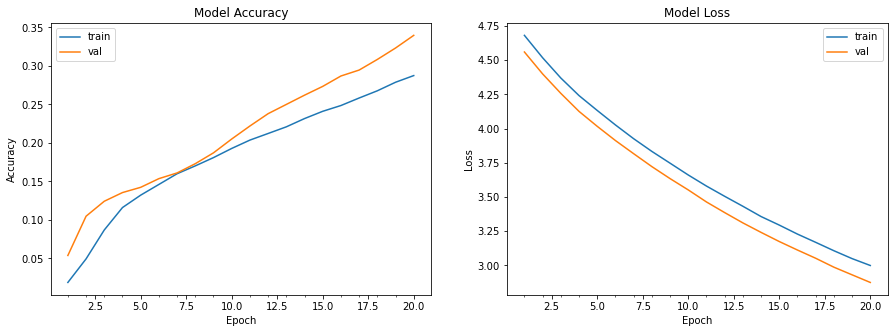

454/454 [==============================] - 10s 23ms/step


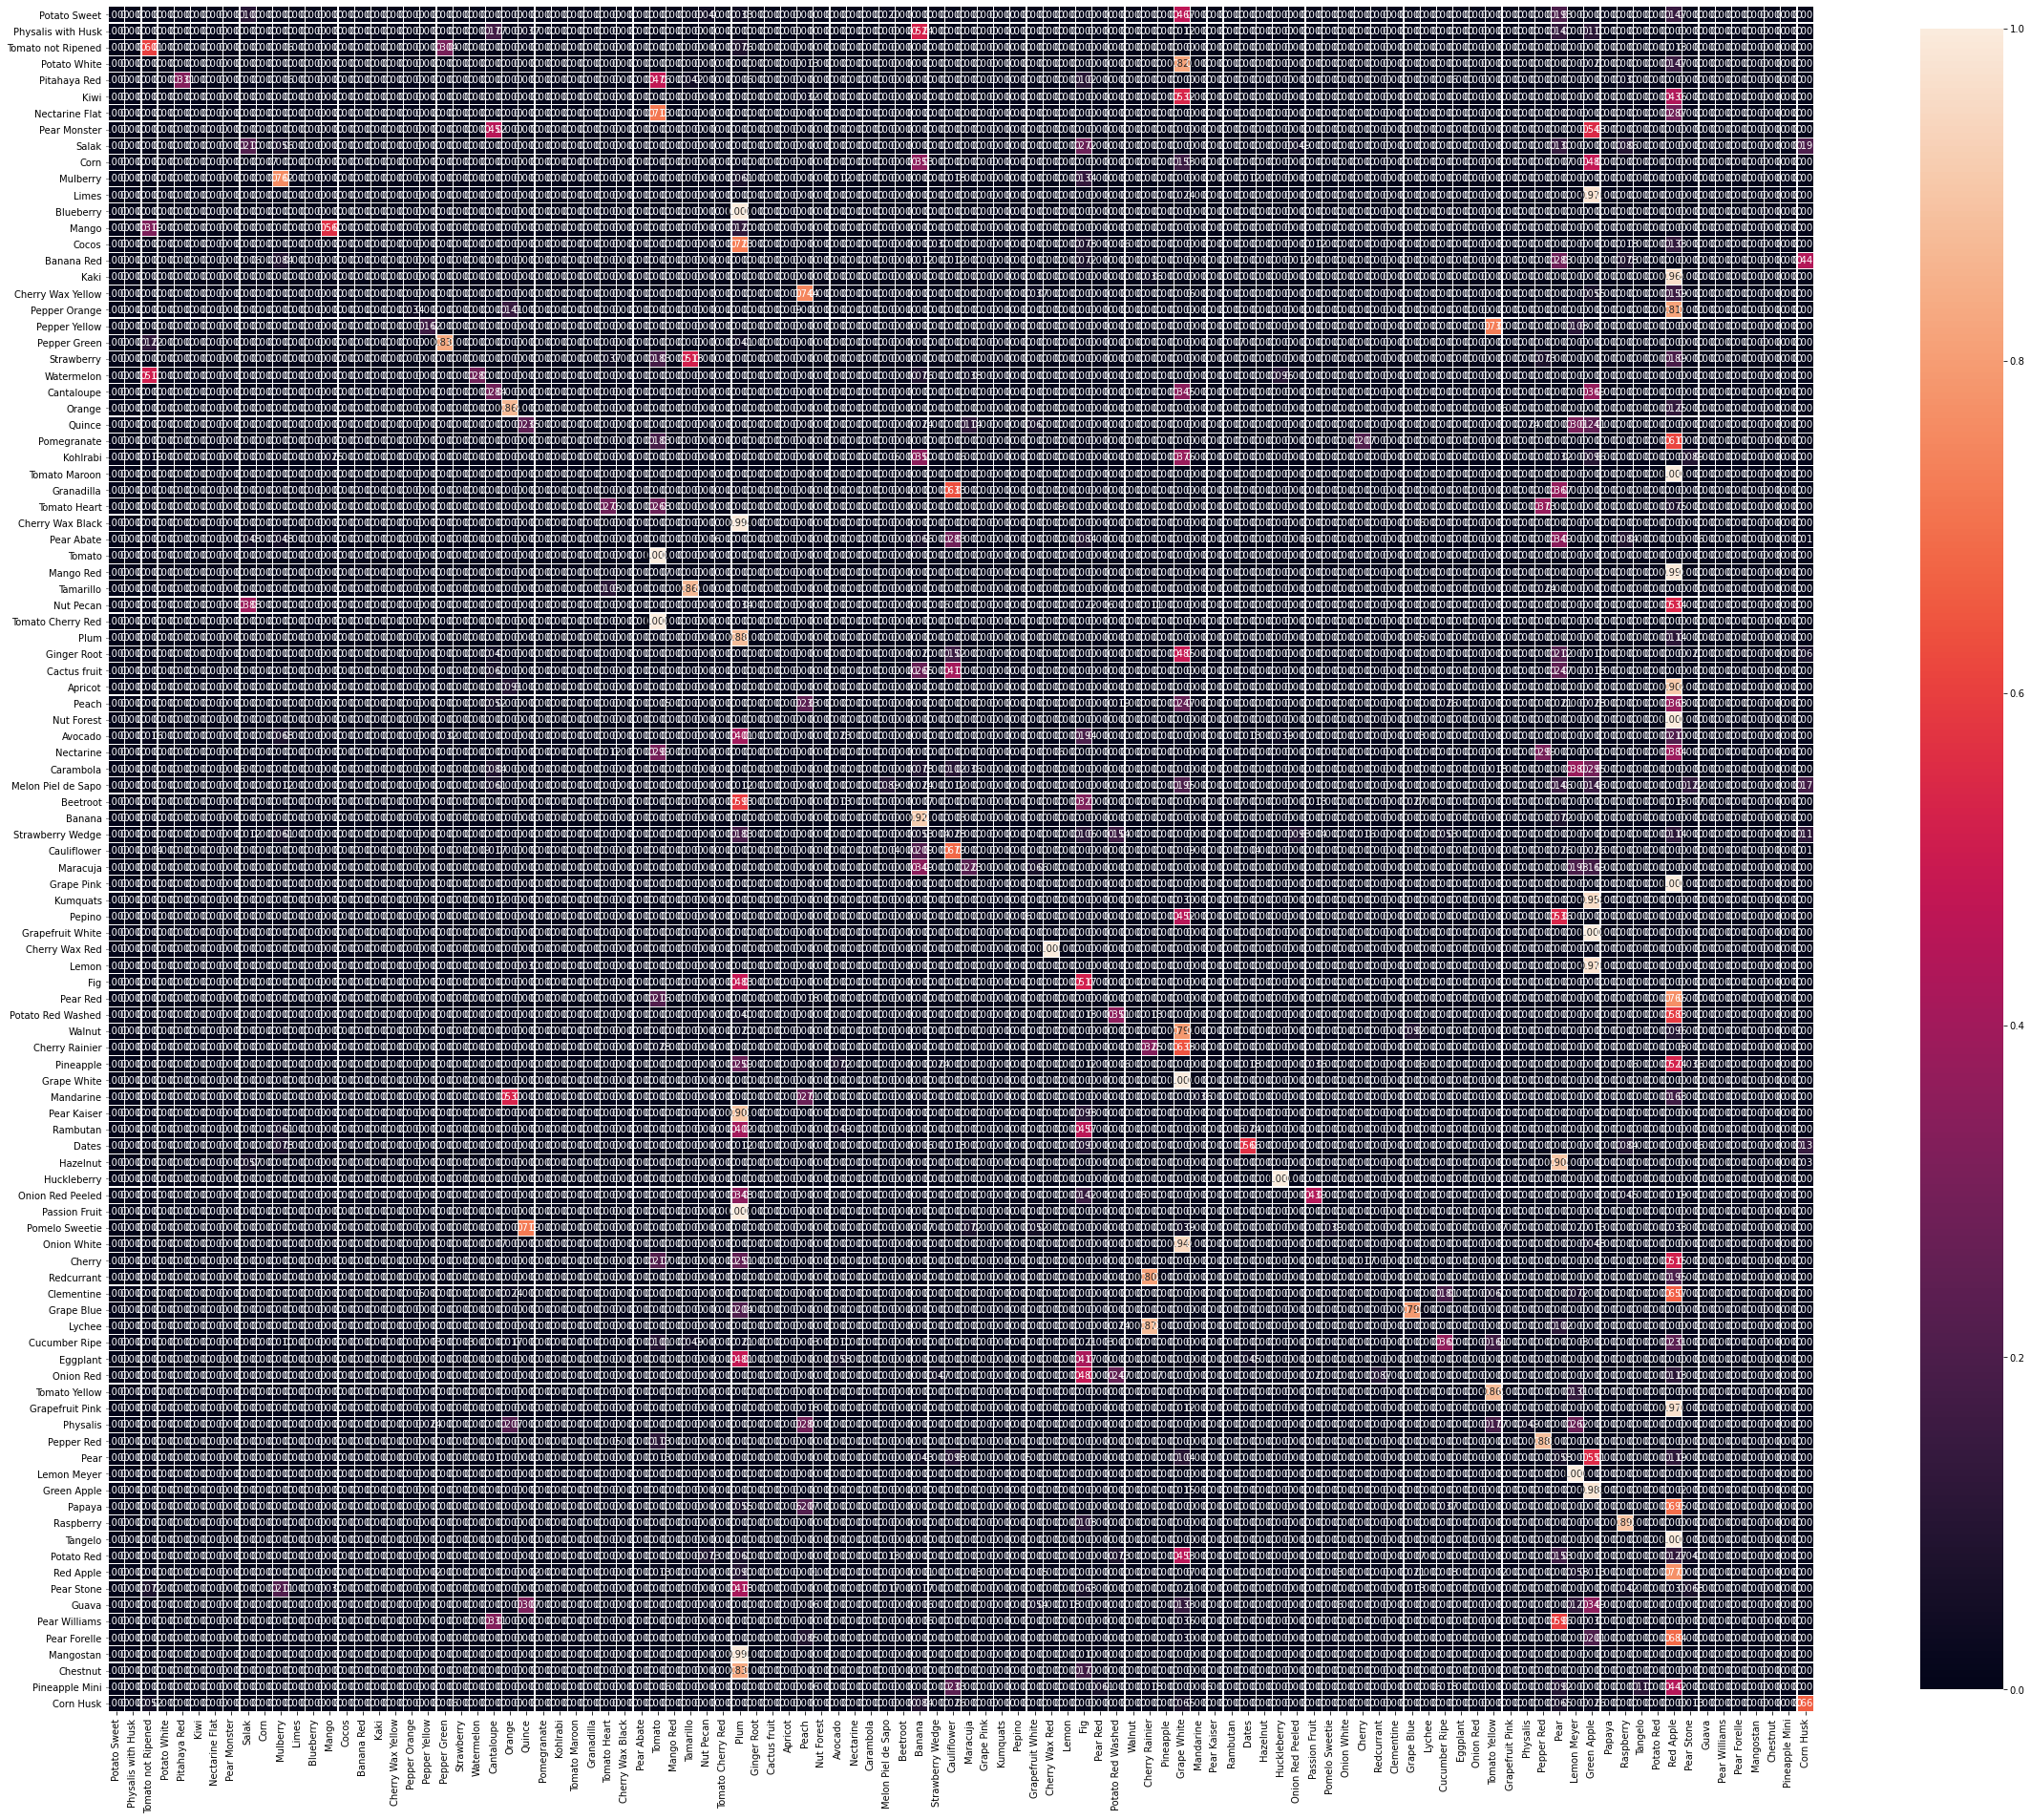

In [25]:
model = network_three(input_shape=input_shape, num_classes=num_classes)
optimizer = Adadelta(lr=learning_rate)
train_and_evaluate_model(model, "n3-delta", optimizer, epochs=20, convert=True)

In [26]:
def network_mini(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='valid', name='pool1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='valid', name='pool2')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 16)        1216      
_________________________________________________________________
conv1_relu (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 12, 12, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 12, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 32)          12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 6, 6, 32)          0   

1219/1219 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9853 - batch_accuracy: 1.0000
Epoch 00015: val_accuracy improved from 0.96100 to 0.97094, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-46-21\model-nmini-adamTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 0.0436 - accuracy: 0.9853 - batch_accuracy: 1.0000 - val_loss: 0.1621 - val_accuracy: 0.9709 - val_batch_accuracy: 1.0000
Epoch 16/20
1218/1219 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9842 - batch_accuracy: 0.9800
Epoch 00016: val_accuracy did not improve from 0.97094
1219/1219 [==============================] - 33s 27ms/step - loss: 0.0471 - accuracy: 0.9842 - batch_accuracy: 0.9800 - val_loss: 0.1672 - val_accuracy: 0.9632 - val_batch_accuracy: 1.0000
Epoch 17/20
1219/1219 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9853 - batch_accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


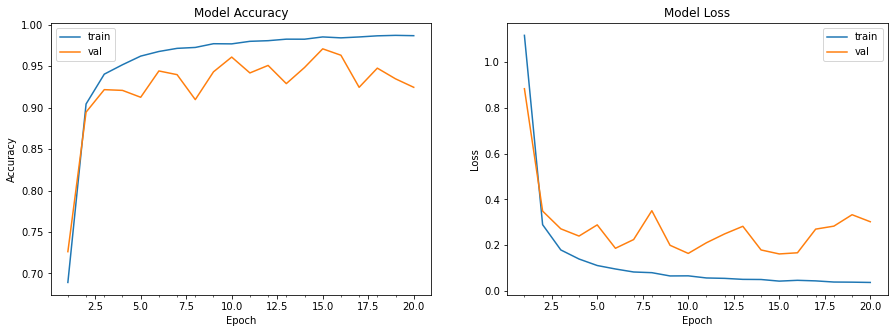

454/454 [==============================] - 10s 22ms/step


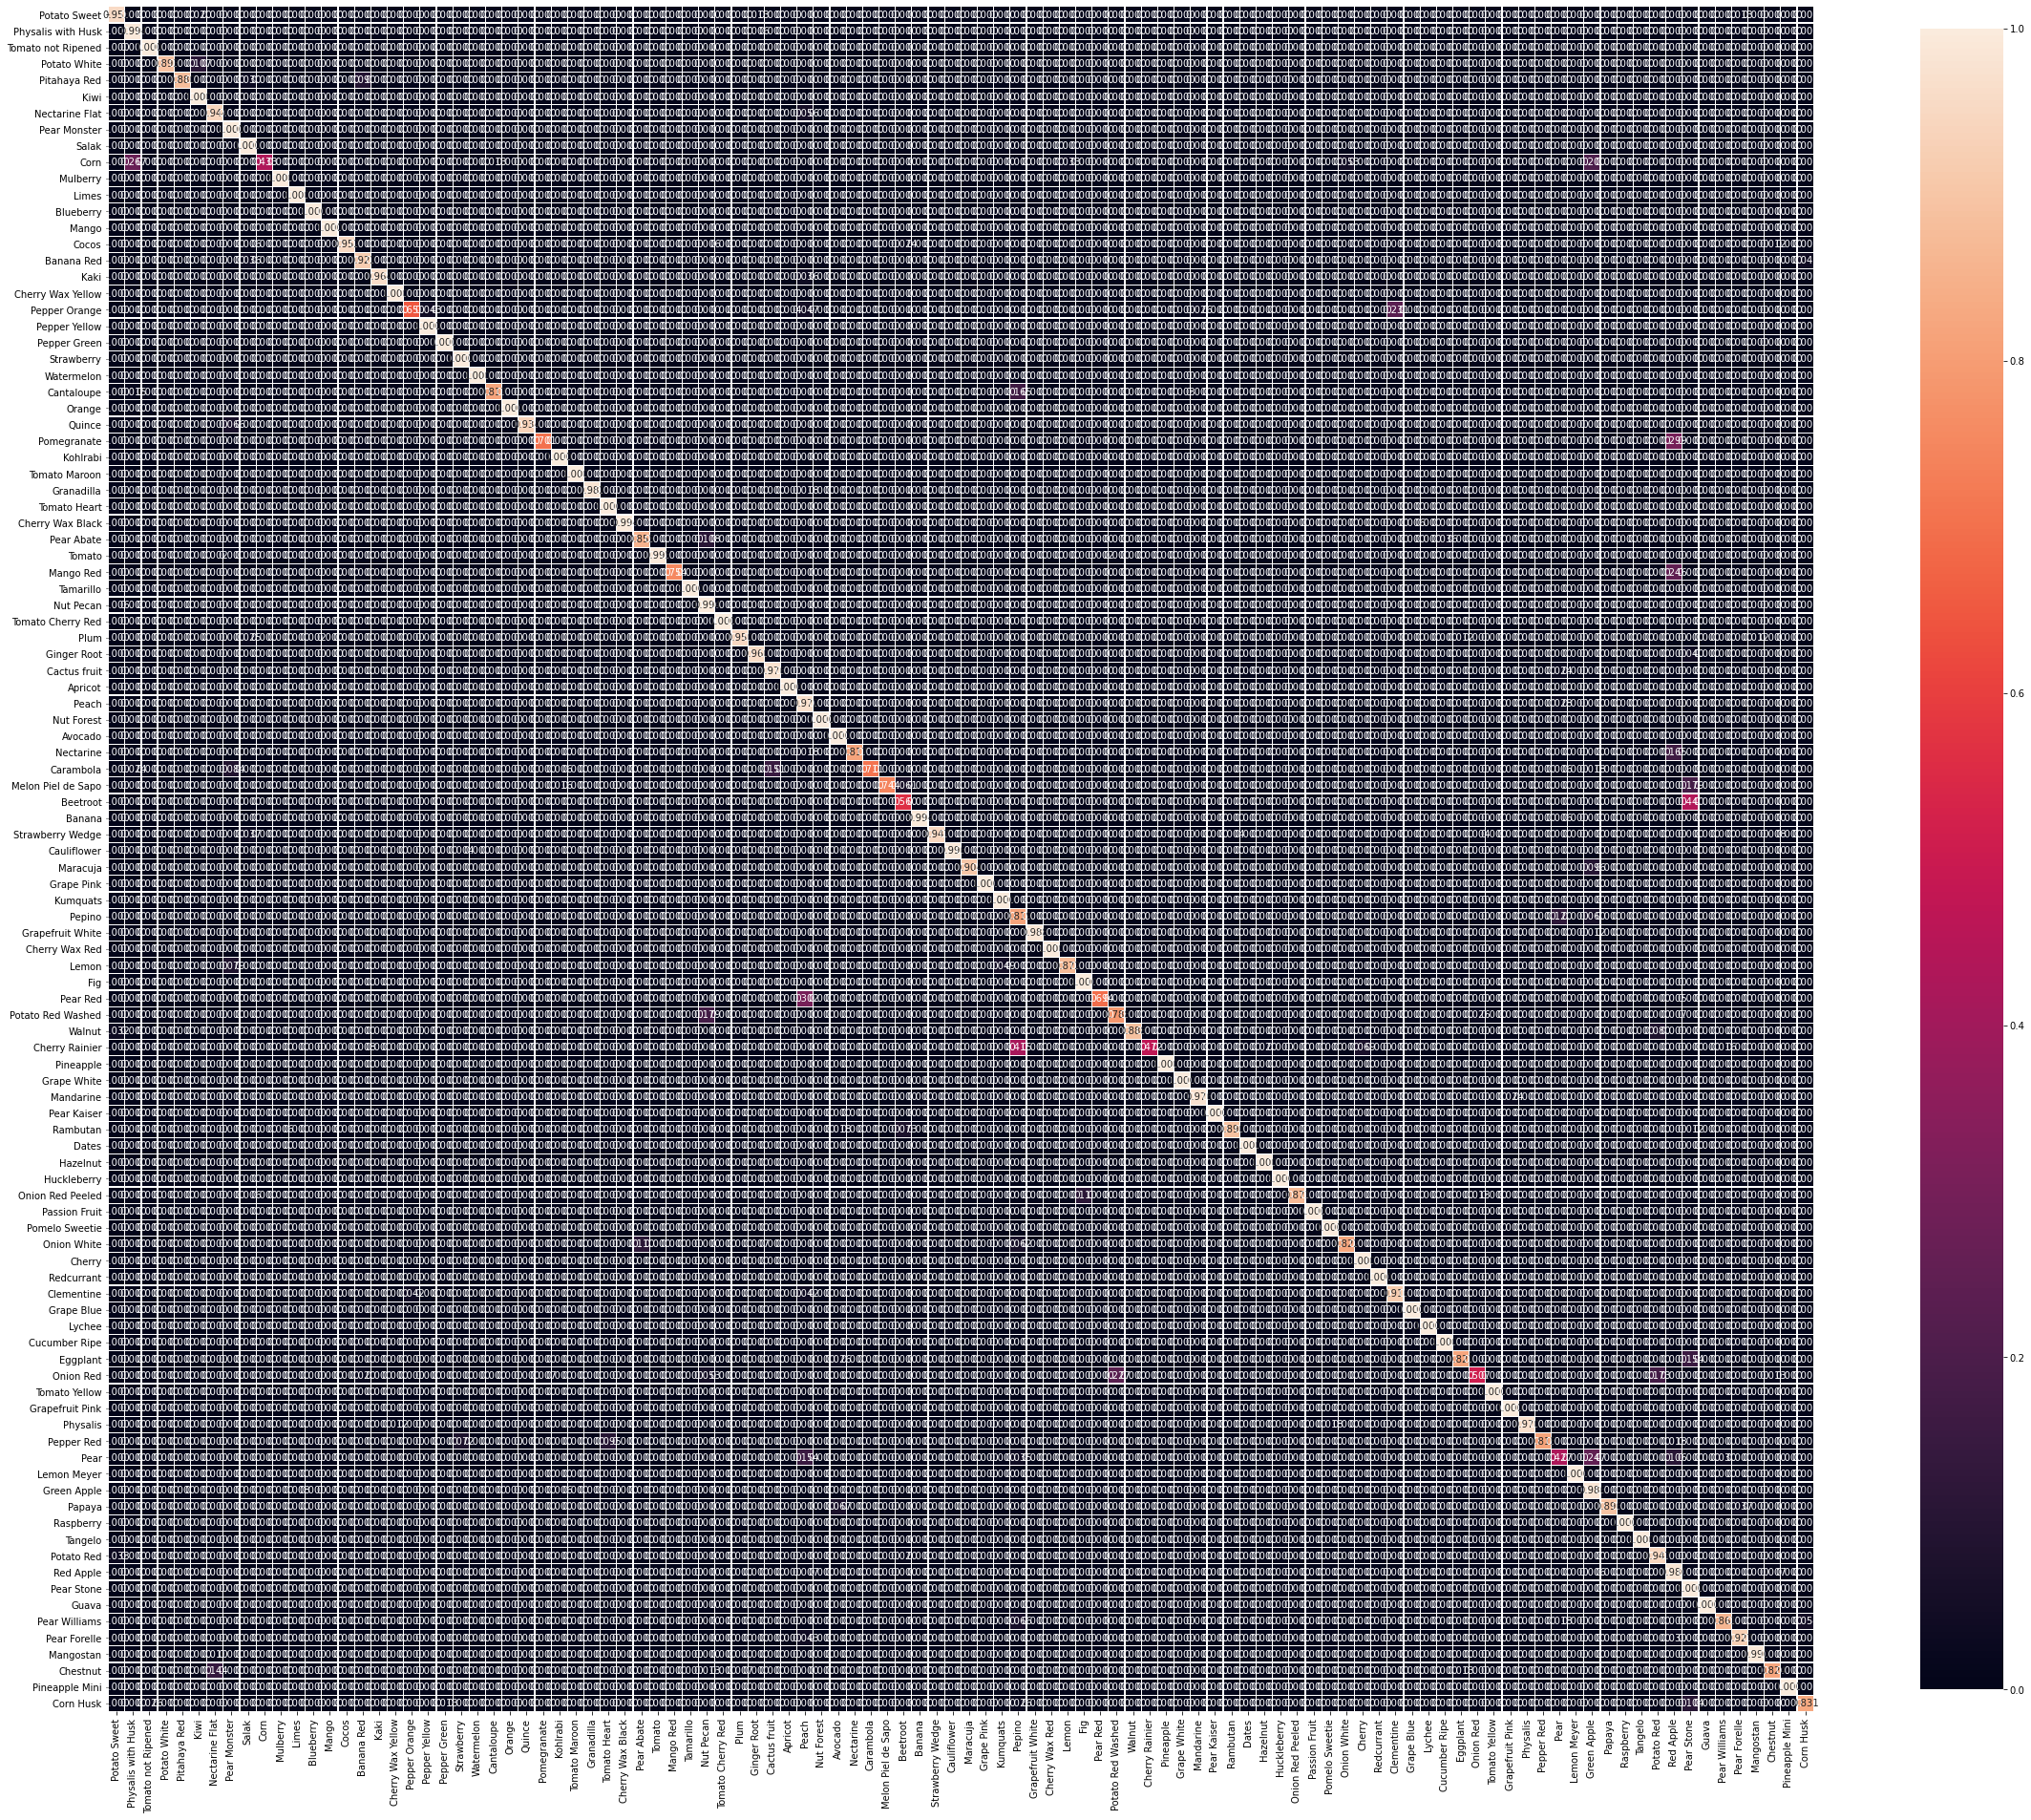

In [27]:
model = network_mini(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "nmini-adam", optimizer, epochs=20, convert=True)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 16)        1216      
_________________________________________________________________
conv1_relu (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 12, 12, 16)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 12, 12, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 32)          12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 6, 6, 32)          0   

1217/1219 [============================>.] - ETA: 0s - loss: 4.2163 - accuracy: 0.0948 - batch_accuracy: 0.1400
Epoch 00013: val_accuracy improved from 0.09668 to 0.10320, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-59-32\model-nmini-deltaTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 4.2161 - accuracy: 0.0948 - batch_accuracy: 0.1400 - val_loss: 4.1597 - val_accuracy: 0.1032 - val_batch_accuracy: 0.0000e+00
Epoch 14/20
1217/1219 [============================>.] - ETA: 0s - loss: 4.1715 - accuracy: 0.1009 - batch_accuracy: 0.0600
Epoch 00014: val_accuracy improved from 0.10320 to 0.10958, saving model to C:\Users\Previato\divertidamente\Results\07-08-2020-17-59-32\model-nmini-deltaTrue.h5
1219/1219 [==============================] - 33s 27ms/step - loss: 4.1711 - accuracy: 0.1010 - batch_accuracy: 0.1800 - val_loss: 4.1132 - val_accuracy: 0.1096 - val_batch_accuracy: 0.0000e+00
Epoch 15/20
1219/1219 [==============================]

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


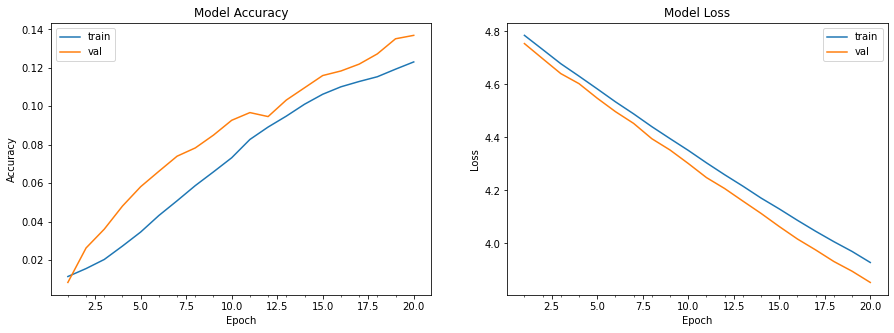

454/454 [==============================] - 10s 22ms/step


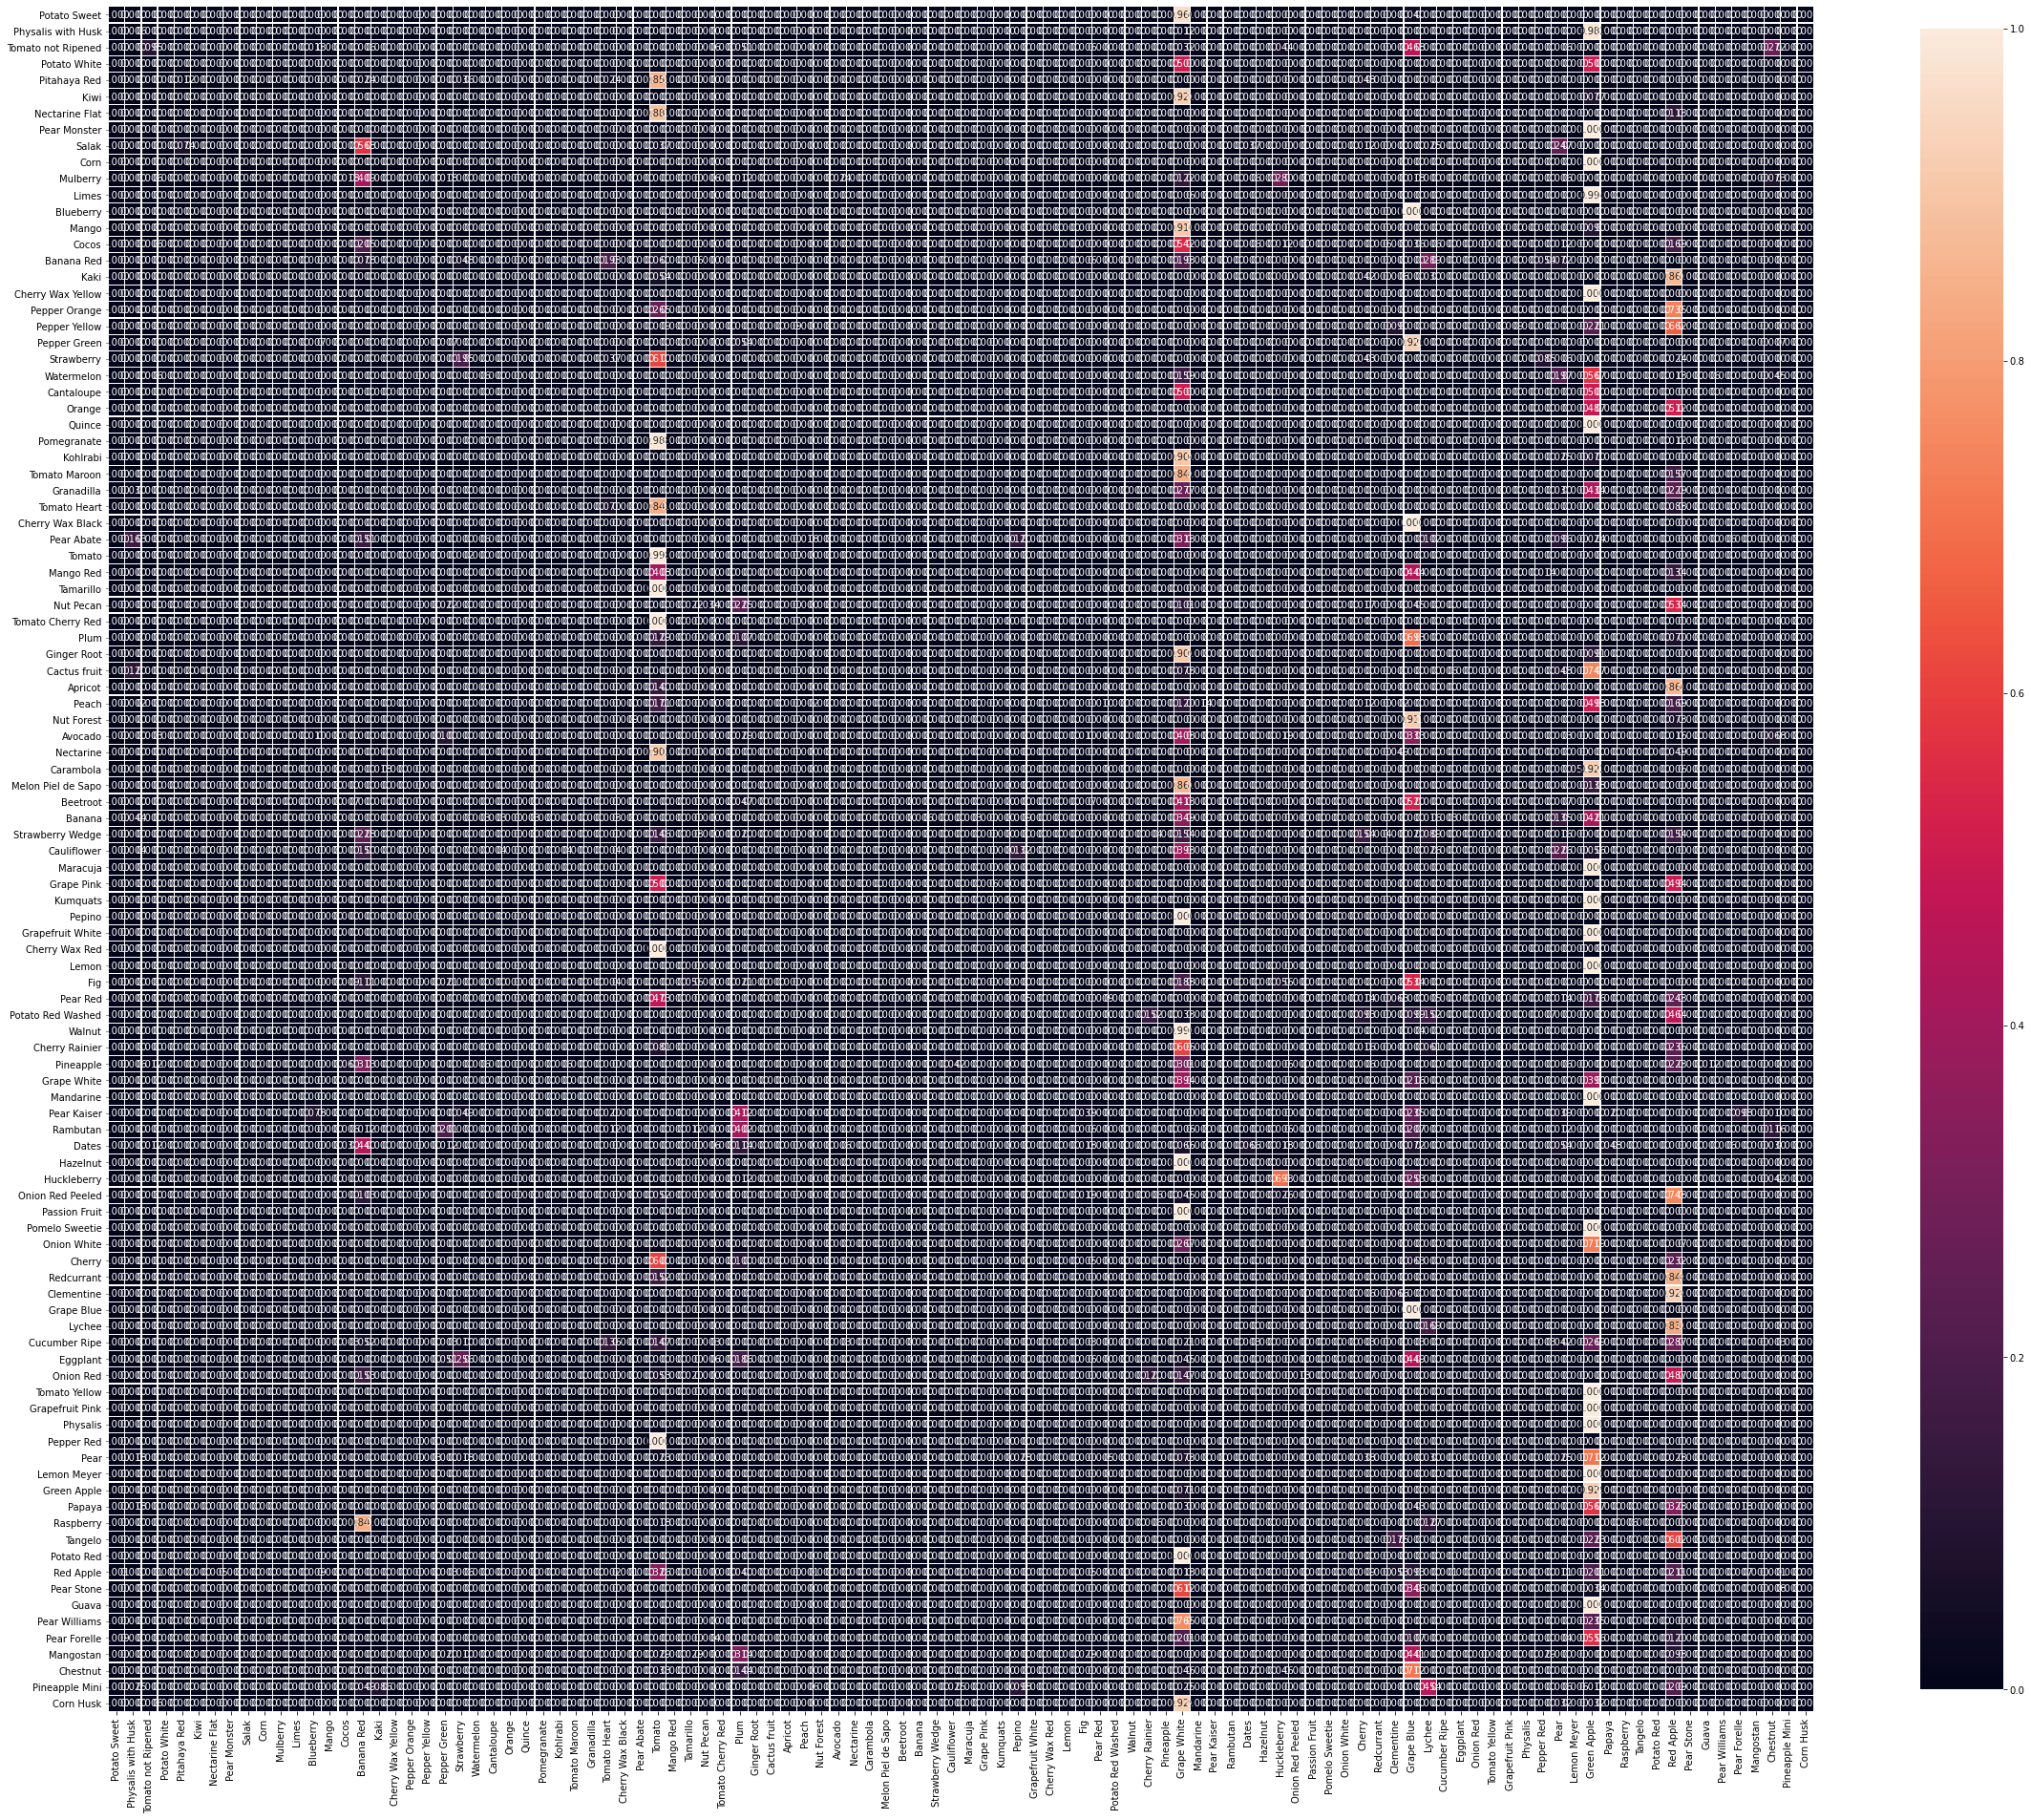

In [28]:
model = network_mini(input_shape=input_shape, num_classes=num_classes)
optimizer = Adadelta(lr=learning_rate)
train_and_evaluate_model(model, "nmini-delta", optimizer, epochs=20, convert=True)

In [29]:
def network_cnnPaper(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(convert_to_hsv_and_grayscale)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

1219/1219 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9643 - batch_accuracy: 0.9200- ETA: 7s 
Epoch 00012: val_accuracy did not improve from 0.93609
1219/1219 [==============================] - 34s 28ms/step - loss: 0.1548 - accuracy: 0.9643 - batch_accuracy: 0.9200 - val_loss: 0.4747 - val_accuracy: 0.9063 - val_batch_accuracy: 1.0000
Epoch 13/20
1219/1219 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9662 - batch_accuracy: 0.9000
Epoch 00013: val_accuracy did not improve from 0.93609
1219/1219 [==============================] - 34s 28ms/step - loss: 0.1470 - accuracy: 0.9662 - batch_accuracy: 0.9000 - val_loss: 0.7378 - val_accuracy: 0.9030 - val_batch_accuracy: 1.0000
Epoch 14/20
1218/1219 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9627 - batch_accuracy: 0.9600
Epoch 00014: val_accuracy did not improve from 0.93609
1219/1219 [==============================] - 34s 28ms/step - loss: 0.1646 - accuracy: 0

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


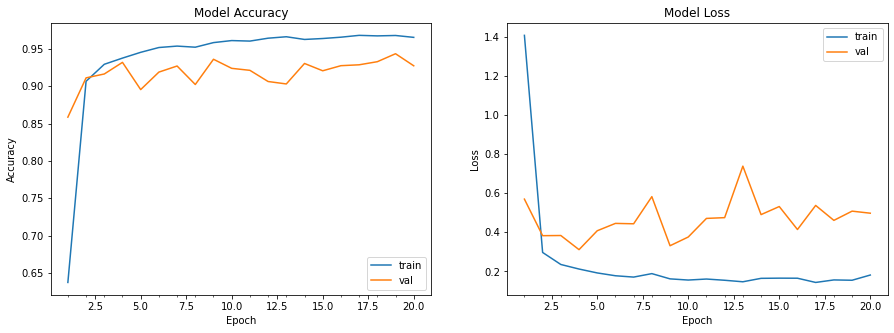

454/454 [==============================] - 10s 23ms/step


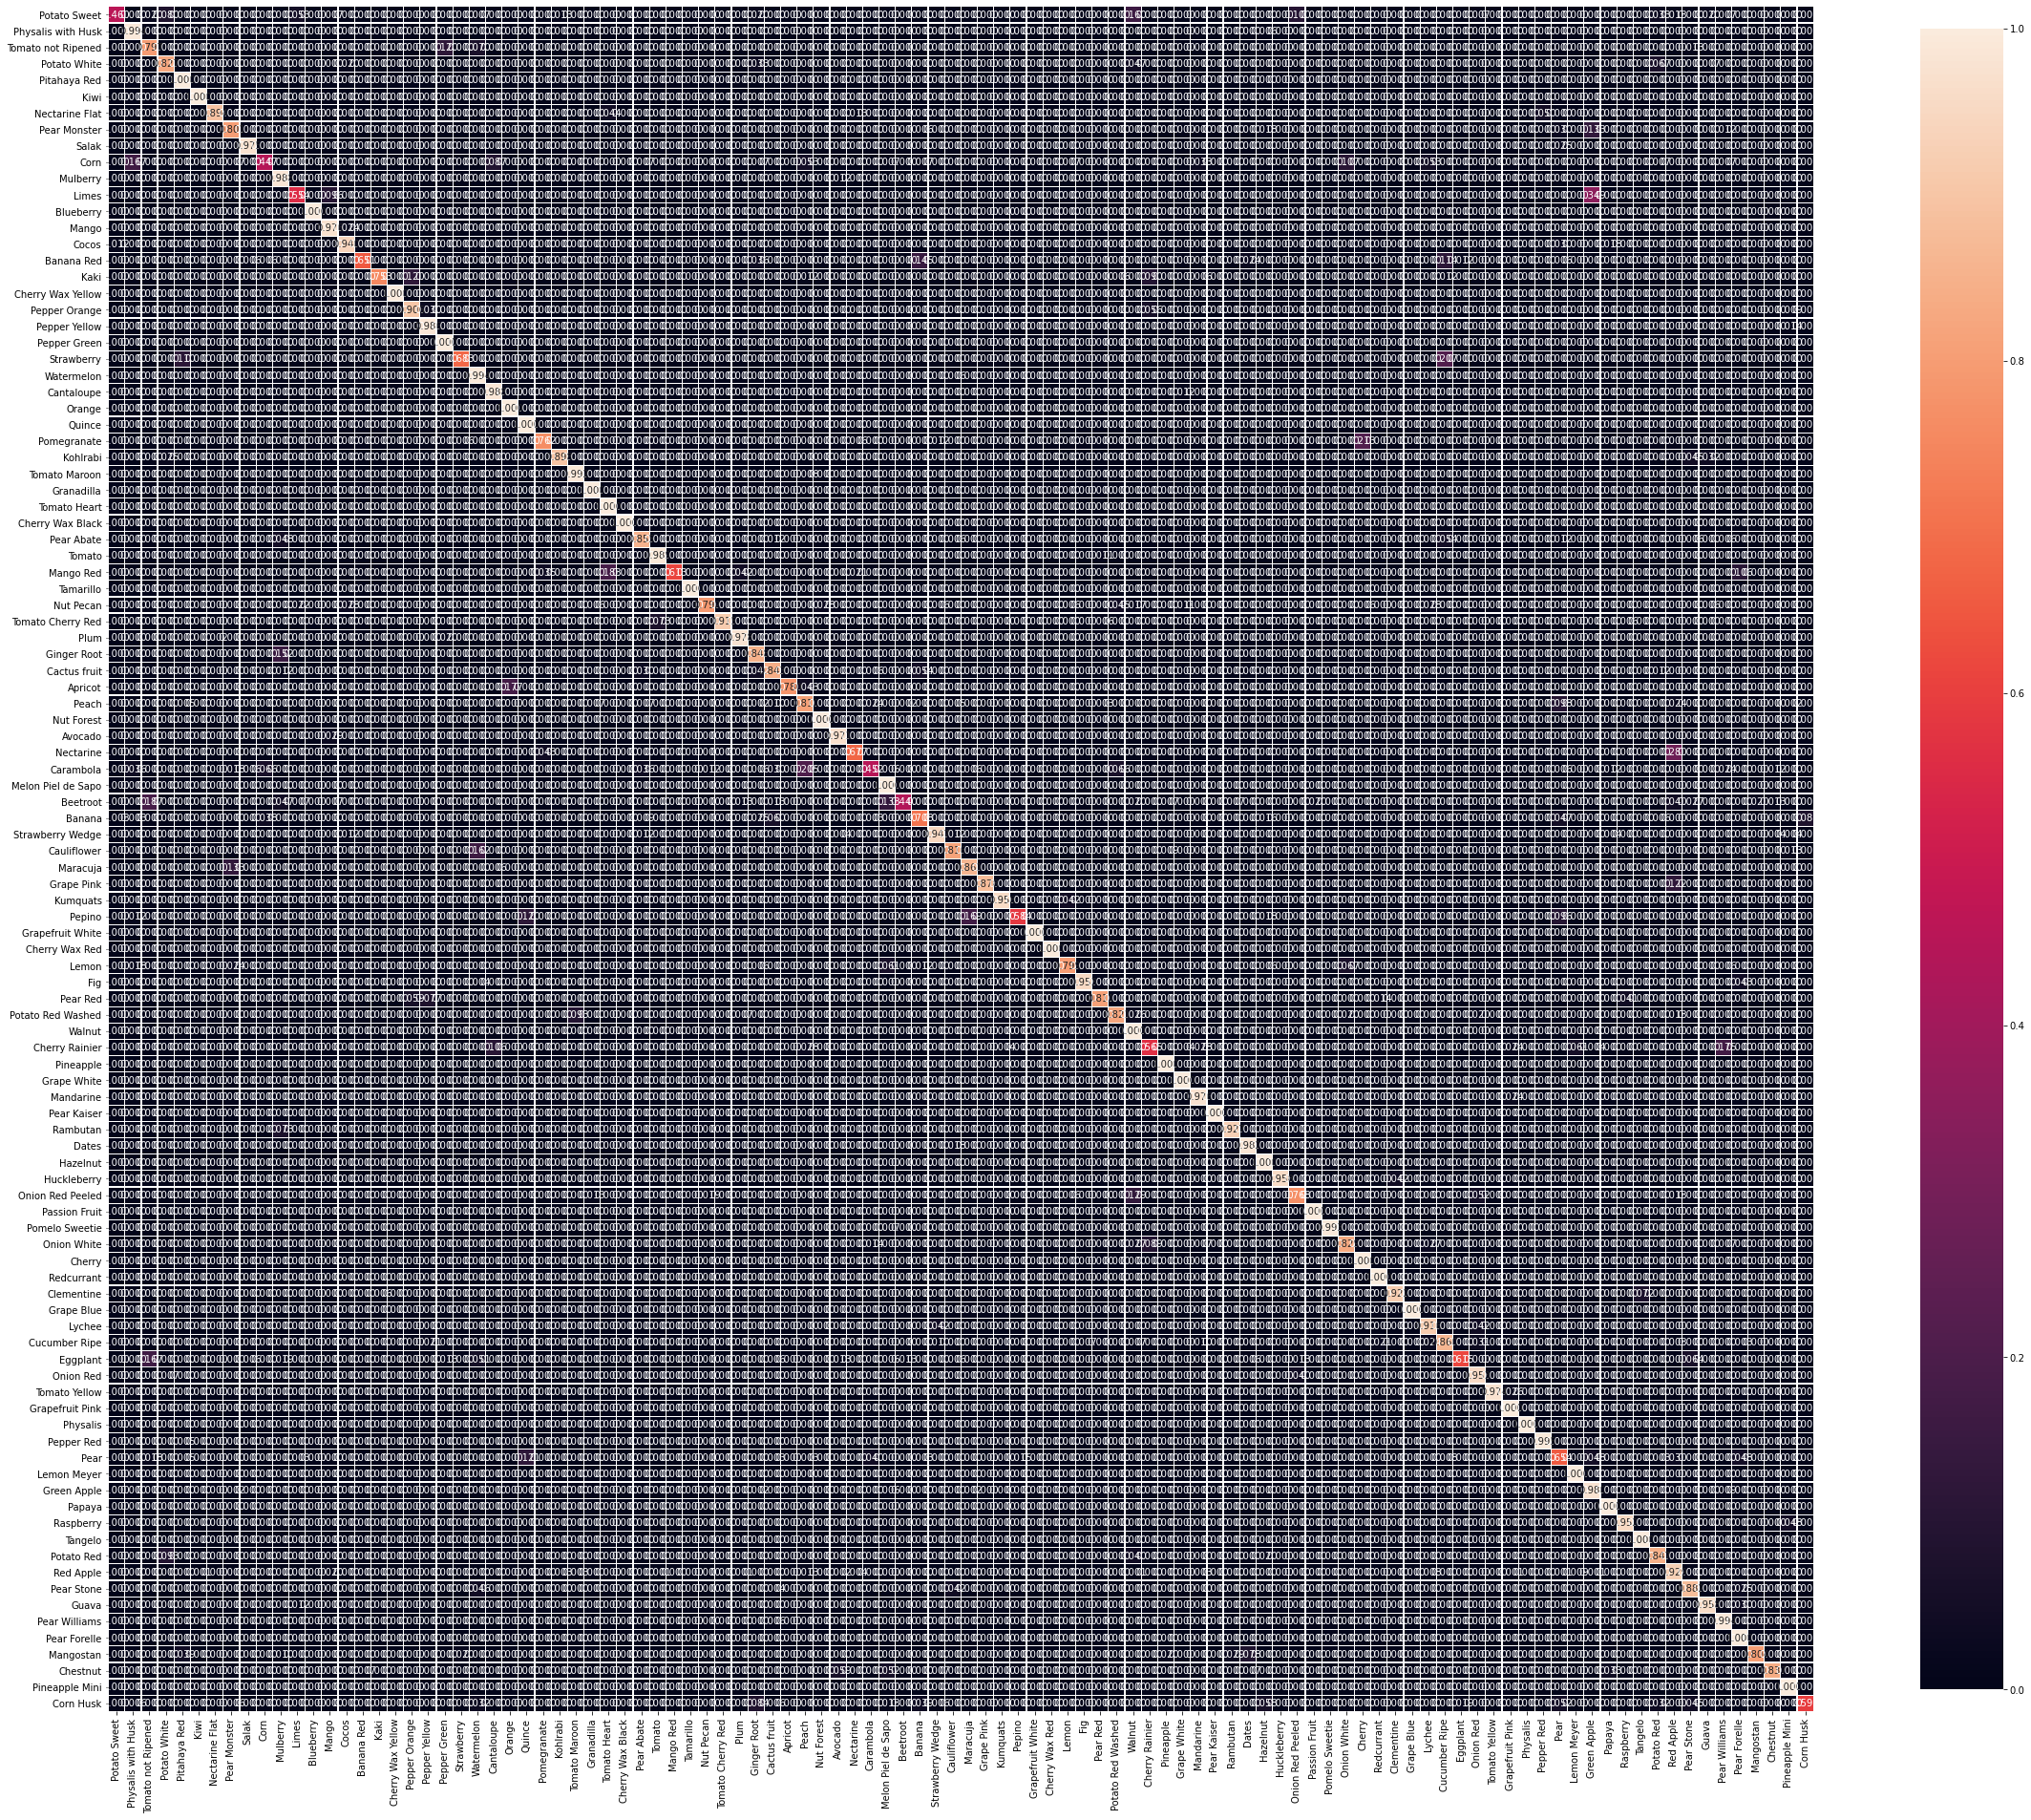

In [30]:
model = network_cnnPaper(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "npaper-adam", optimizer, epochs=20, convert=True)

In [31]:
def VGG_freezes(input_shape, num_classes):
    model = applications.vgg16.VGG16(weights='imagenet' , include_top=False, input_tensor=Input(shape=(100, 100, 3)))
    
    for i in range (19):
        model.layers[i].trainable = False
    #print('Layer ' + model.layers[i].name + ' frozen.')

    #Adicionando Camada de Classificação 
    x = model.layers[-1].output
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    prediction = Dense(num_classes, activation='softmax', name='predictions')(x)

    model_final = Model(model.inputs, prediction)
    return model_final

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

Epoch 12/20
1219/1219 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9895 - batch_accuracy: 0.9800
Epoch 00012: val_accuracy did not improve from 0.96560
1219/1219 [==============================] - 105s 86ms/step - loss: 0.1130 - accuracy: 0.9895 - batch_accuracy: 0.9800 - val_loss: 1.0674 - val_accuracy: 0.9527 - val_batch_accuracy: 1.0000
Epoch 13/20
1219/1219 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9915 - batch_accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.96560
1219/1219 [==============================] - 105s 86ms/step - loss: 0.0965 - accuracy: 0.9915 - batch_accuracy: 1.0000 - val_loss: 0.9553 - val_accuracy: 0.9613 - val_batch_accuracy: 1.0000
Epoch 14/20
1219/1219 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9915 - batch_accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.96560
1219/1219 [==============================] - 105s 86ms/step - loss: 0.1055 - accura

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


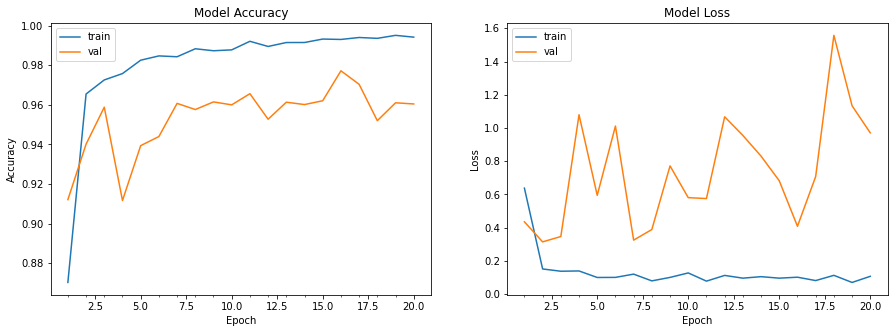

454/454 [==============================] - 34s 76ms/step


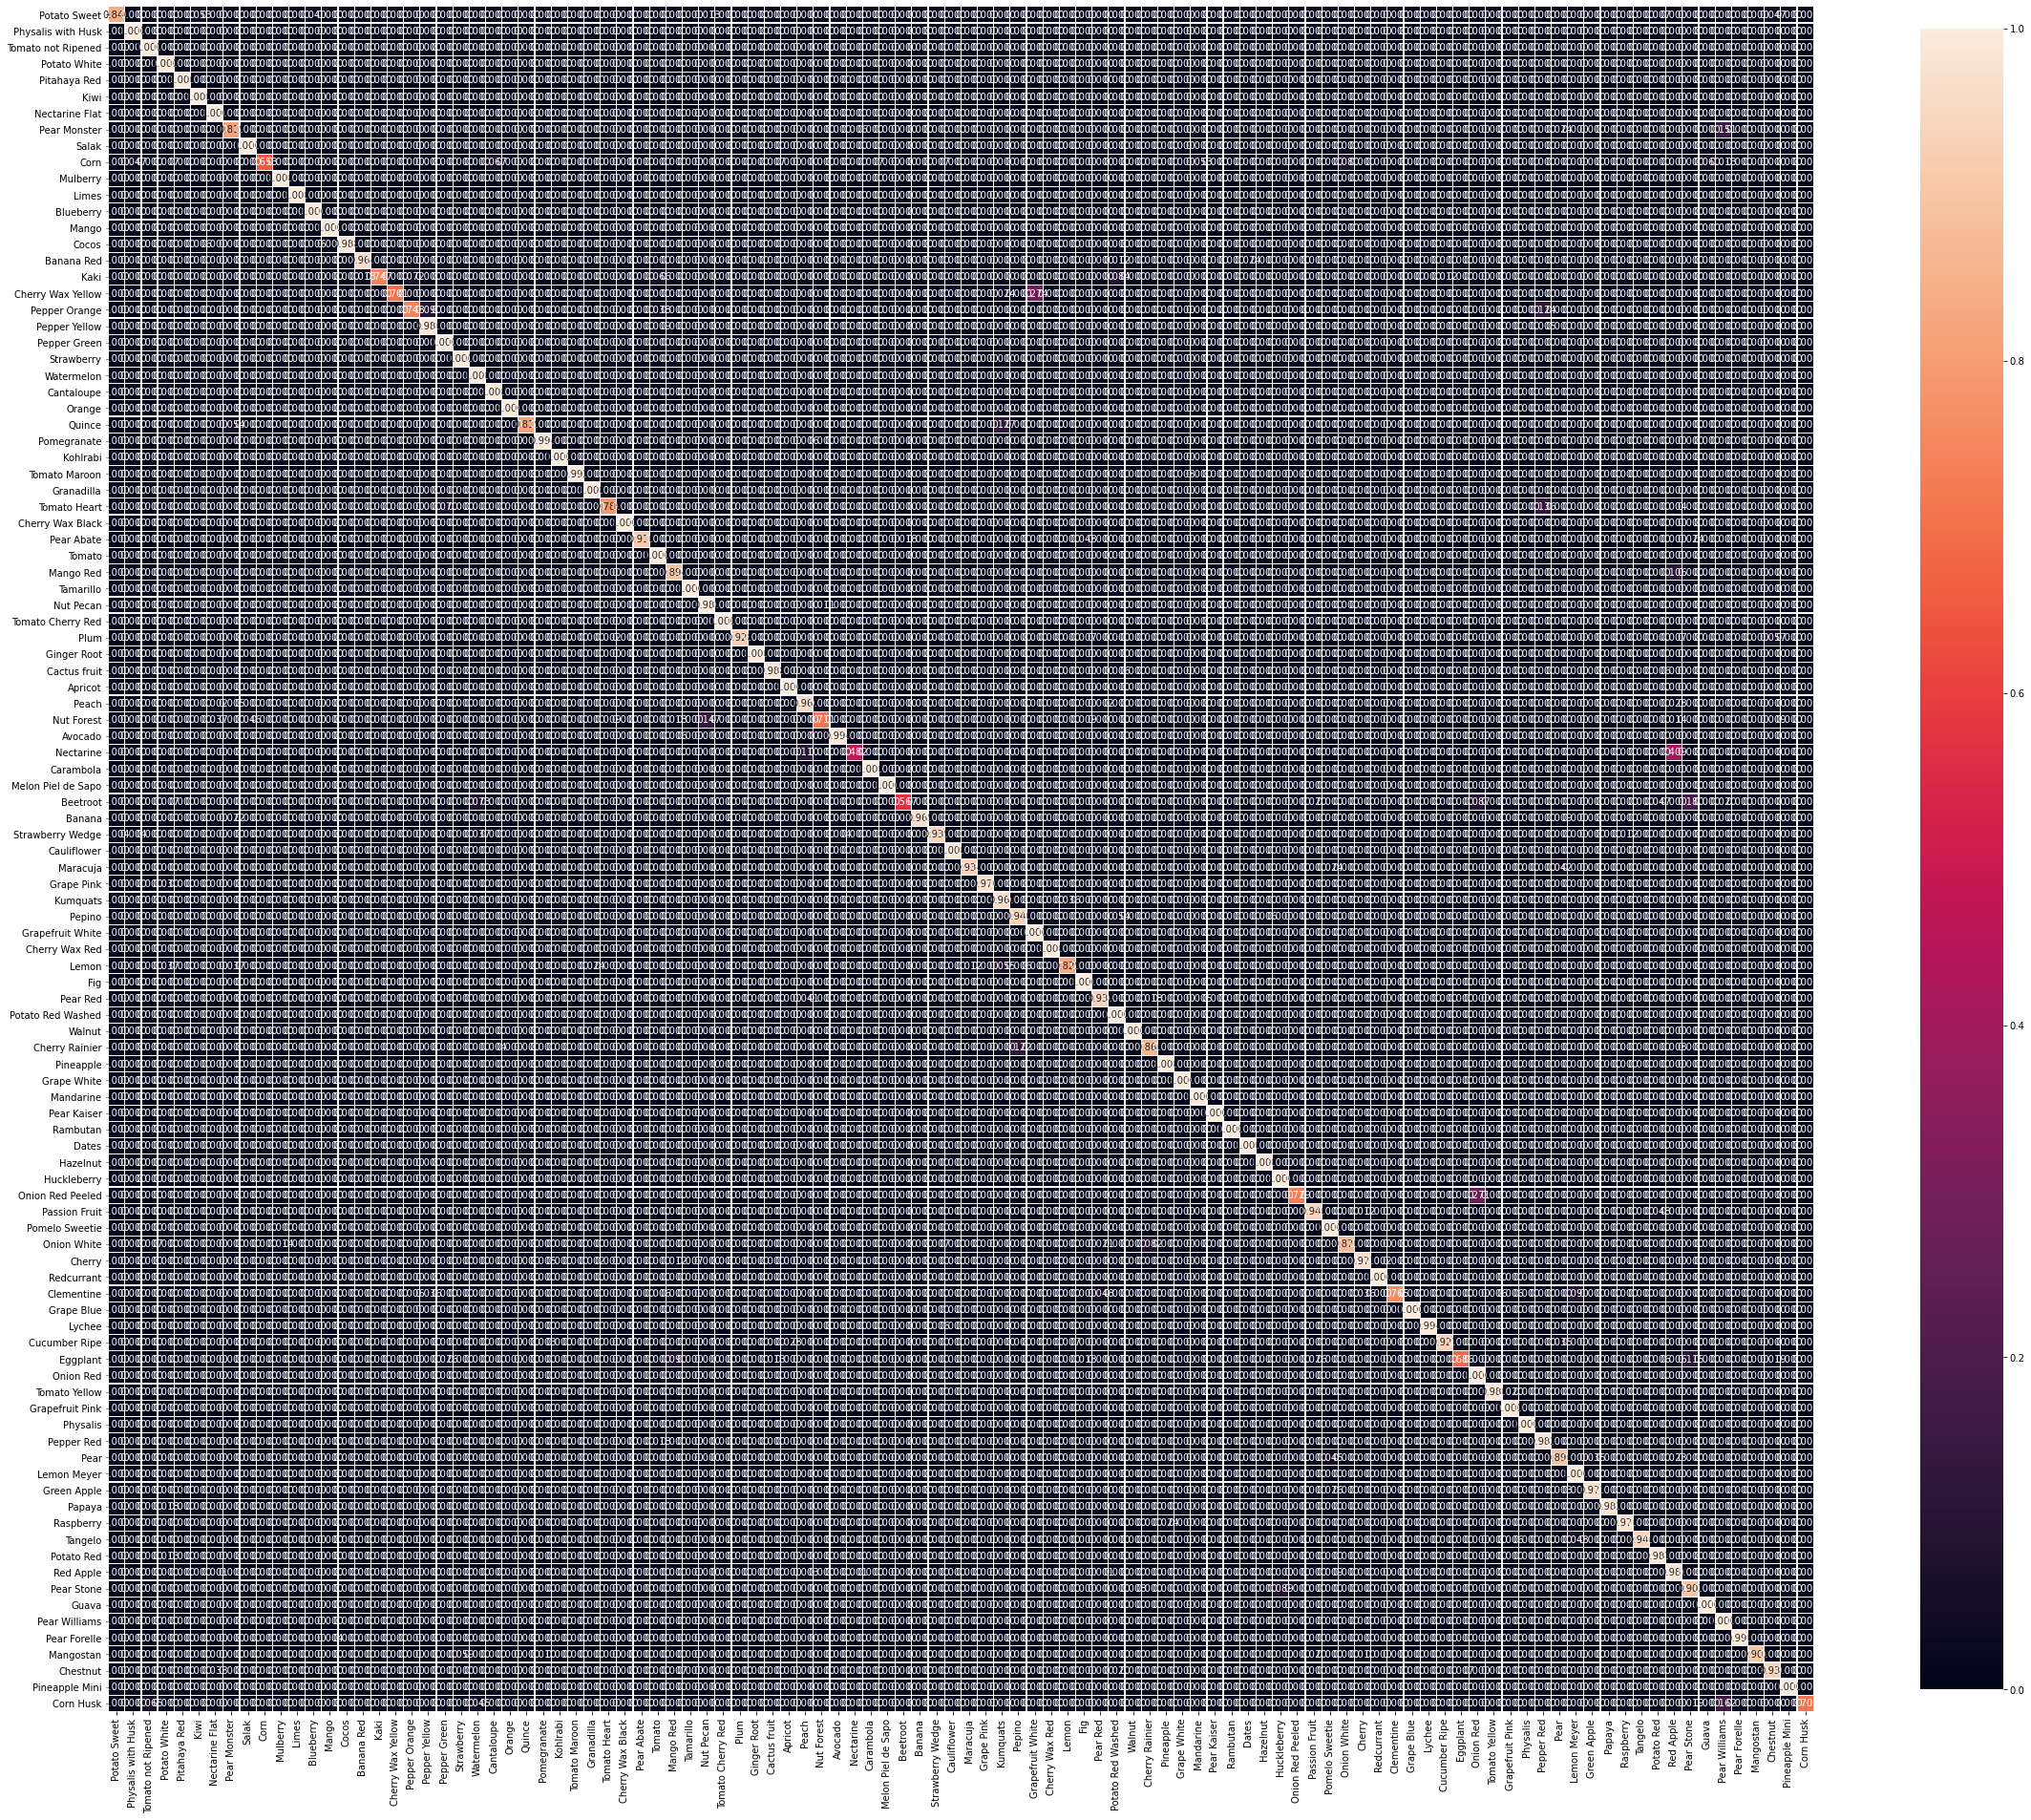

In [32]:
model = VGG_freezes(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "vggFreezes-adam", optimizer, epochs=20, convert=True)

In [33]:
def VGG_full(input_shape, num_classes):
    model = applications.vgg16.VGG16(weights='imagenet' , include_top=False, input_tensor=Input(shape=(100, 100, 3)))

    #Adicionando Camada de Classificação 
    x = model.layers[-1].output
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    prediction = Dense(num_classes, activation='softmax', name='predictions')(x)

    model_final = Model(model.inputs, prediction)
    return model_final

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

Epoch 11/20
1219/1219 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9610 - batch_accuracy: 0.9400
Epoch 00011: val_accuracy did not improve from 0.90421
1219/1219 [==============================] - 269s 221ms/step - loss: 0.1293 - accuracy: 0.9610 - batch_accuracy: 0.9400 - val_loss: 0.5419 - val_accuracy: 0.8806 - val_batch_accuracy: 1.0000
Epoch 12/20
1219/1219 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9744 - batch_accuracy: 0.9600
Epoch 00012: val_accuracy did not improve from 0.90421
1219/1219 [==============================] - 269s 221ms/step - loss: 0.0816 - accuracy: 0.9744 - batch_accuracy: 0.9600 - val_loss: 0.4626 - val_accuracy: 0.8913 - val_batch_accuracy: 1.0000
Epoch 13/20
1219/1219 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9594 - batch_accuracy: 0.9600
Epoch 00013: val_accuracy did not improve from 0.90421
1219/1219 [==============================] - 269s 221ms/step - loss: 0.1433 - acc

<ipython-input-12-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-12-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


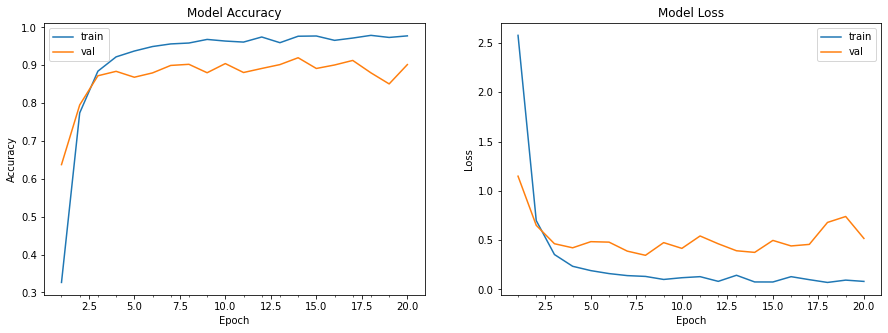

454/454 [==============================] - 35s 77ms/step


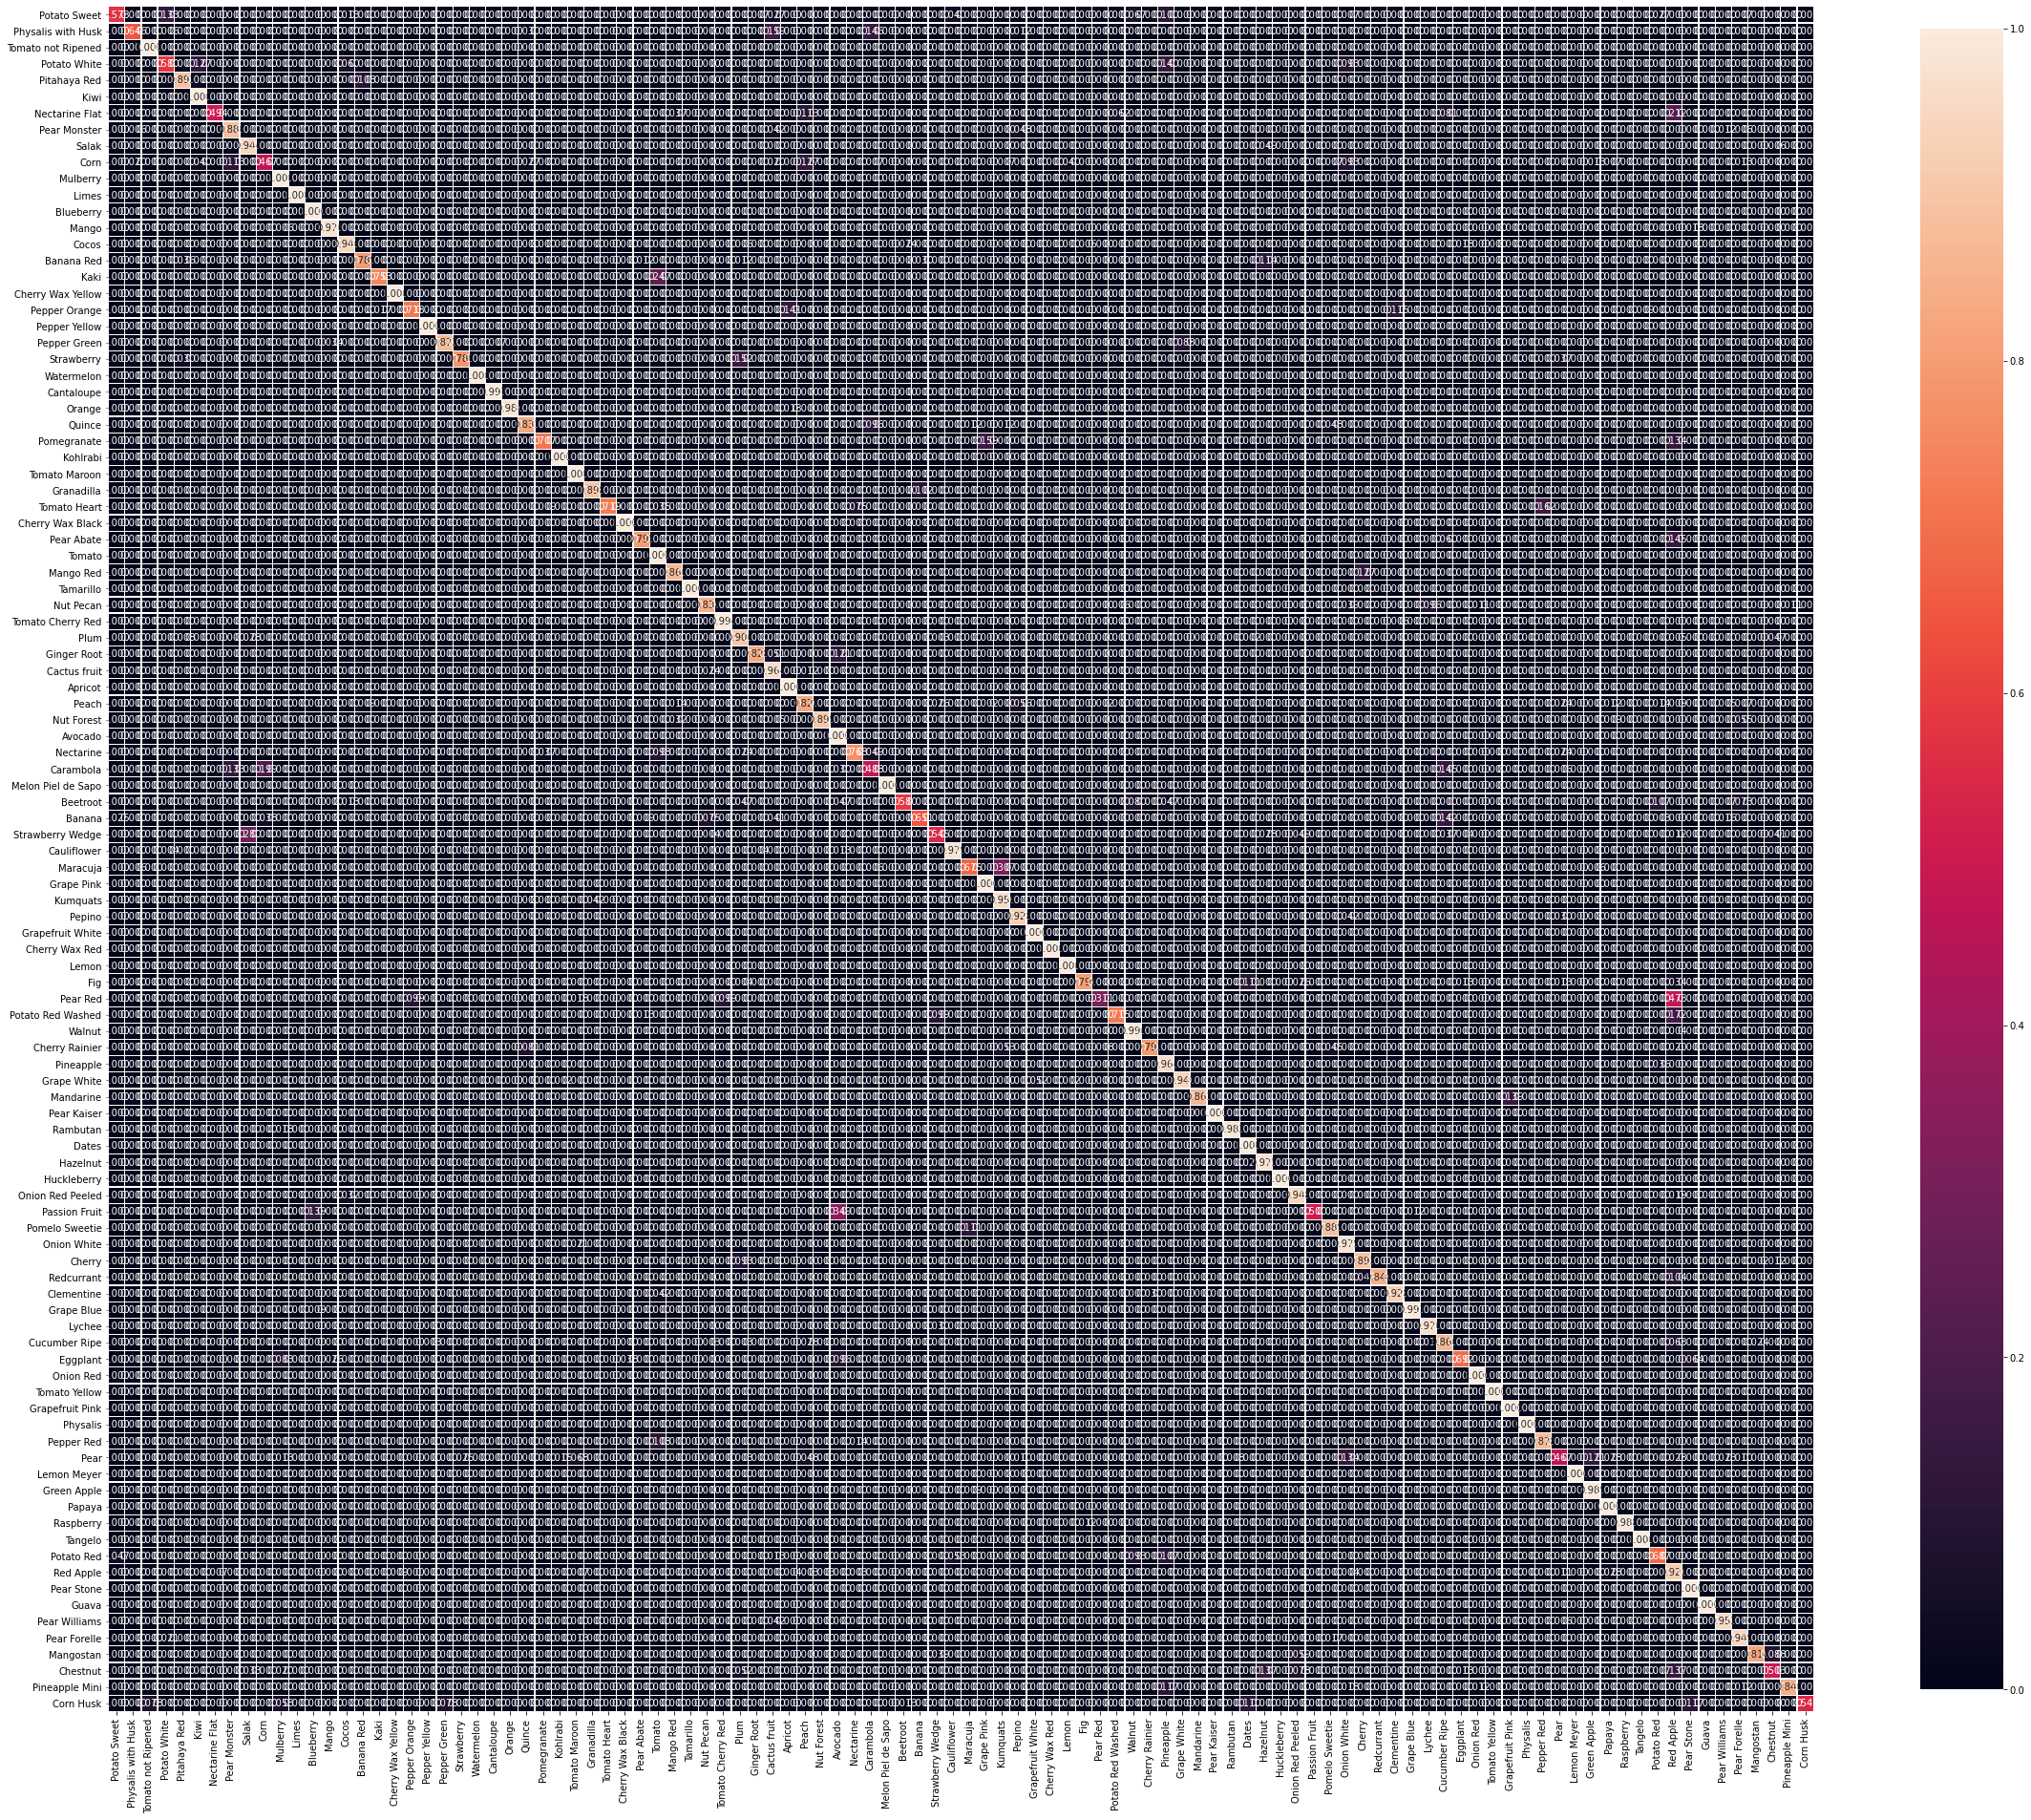

In [34]:
model = VGG_full(input_shape=input_shape, num_classes=num_classes)
optimizer = Adam(lr=learning_rate)
train_and_evaluate_model(model, "vggFull-adam", optimizer, epochs=20, convert=True)